In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter('ignore')

In [2]:
location_ids = [i for i in os.listdir('/ihme/covid-19/deaths/prod/2020_05_03_US/model_data_google_21') if i.endswith('covariate.csv')]
location_ids = [int(i.split('_')[0]) for i in location_ids]
location_ids = sorted(location_ids)

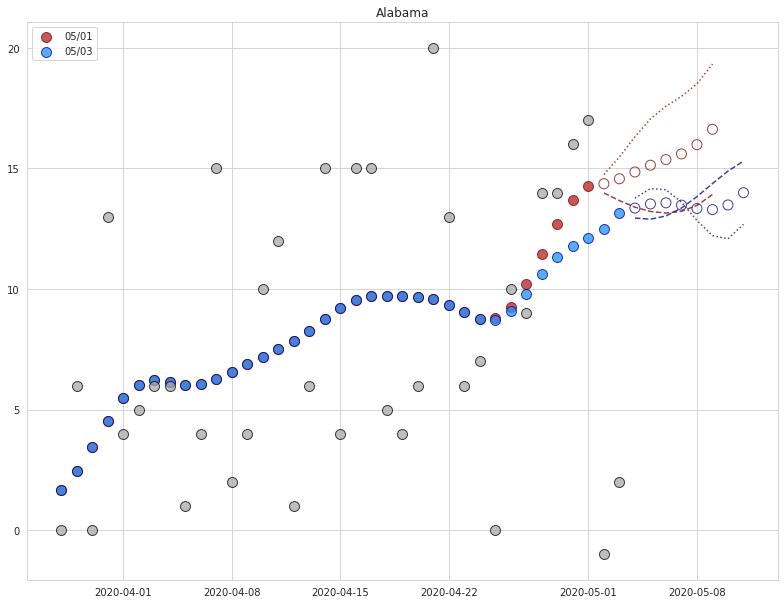

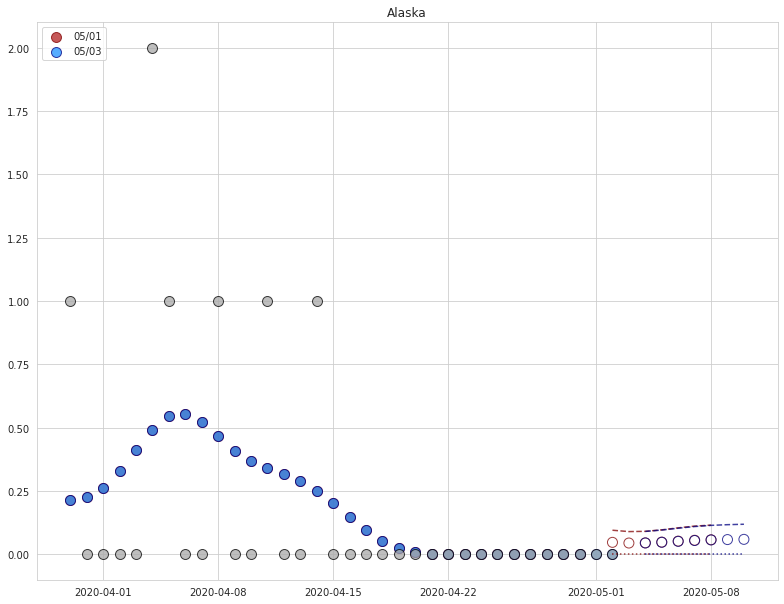

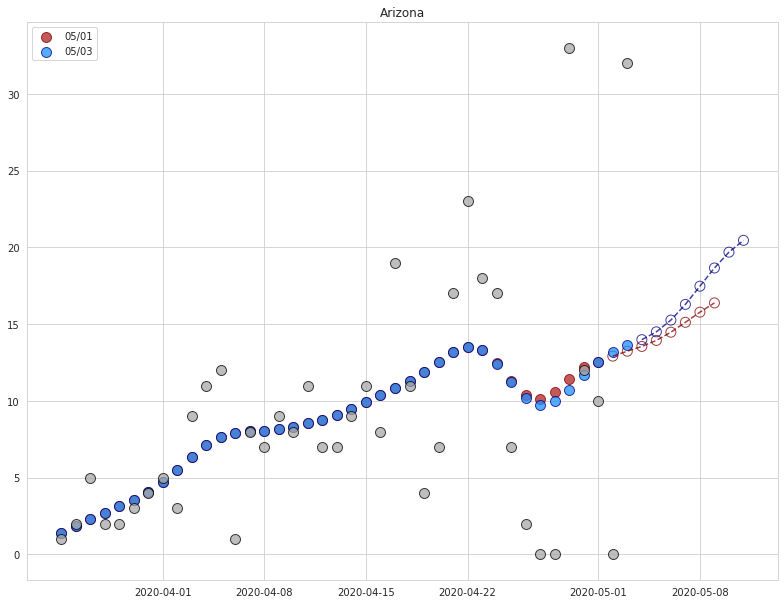

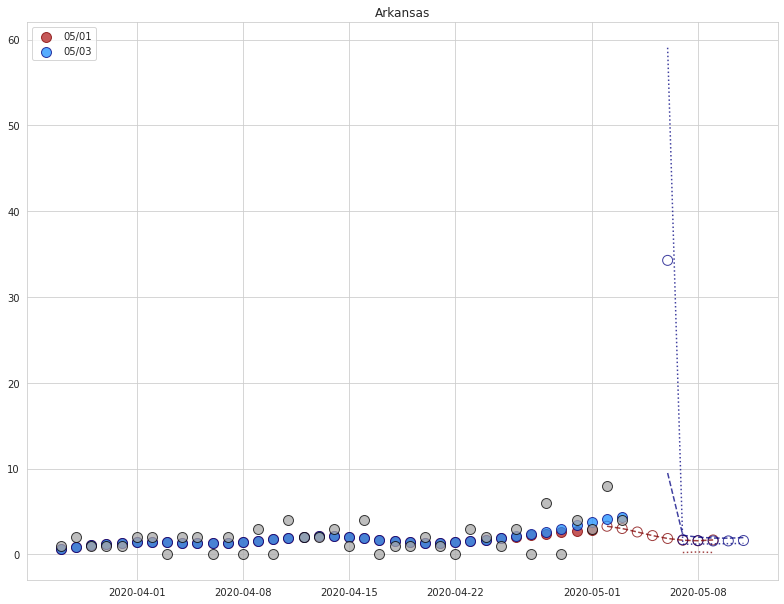

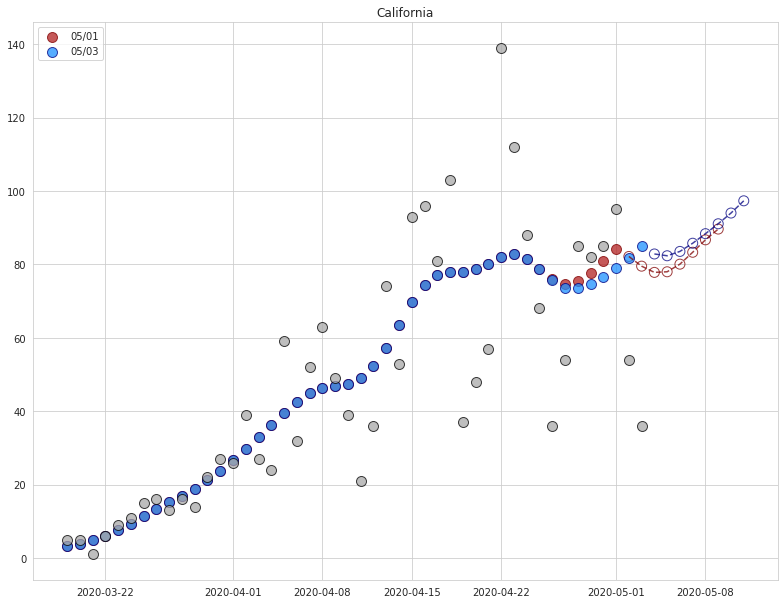

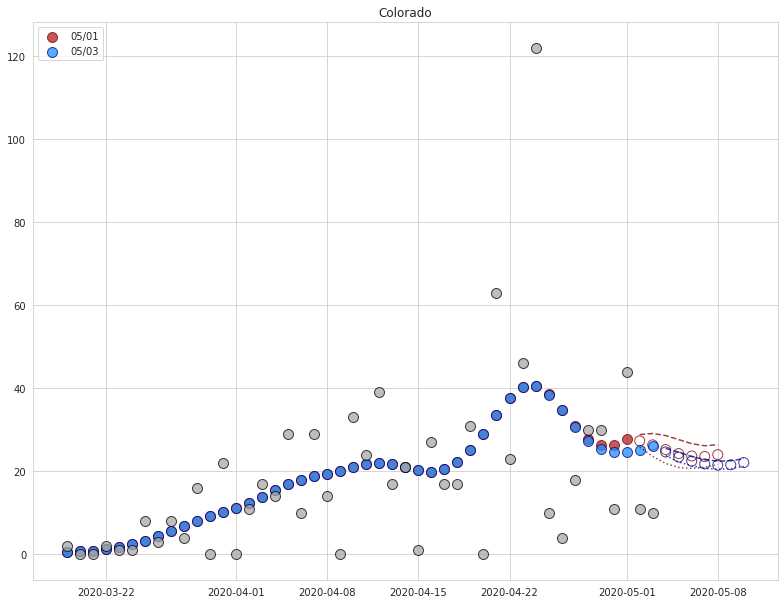

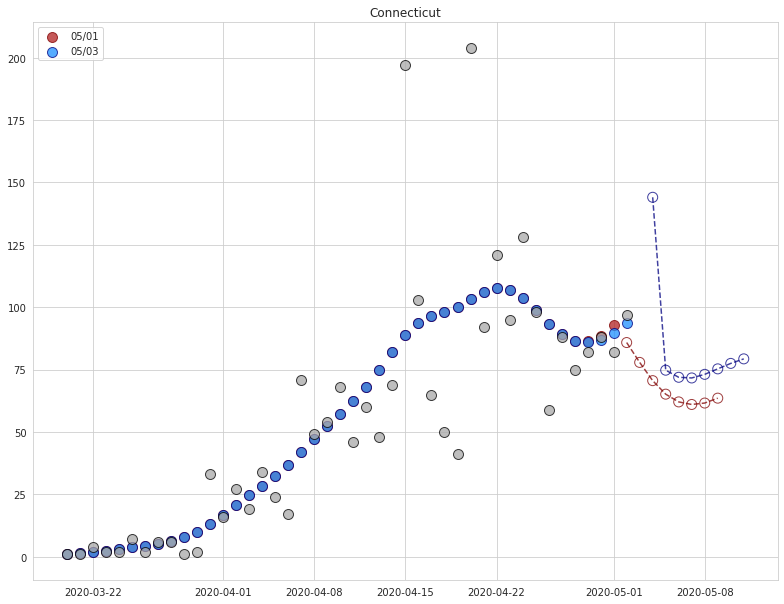

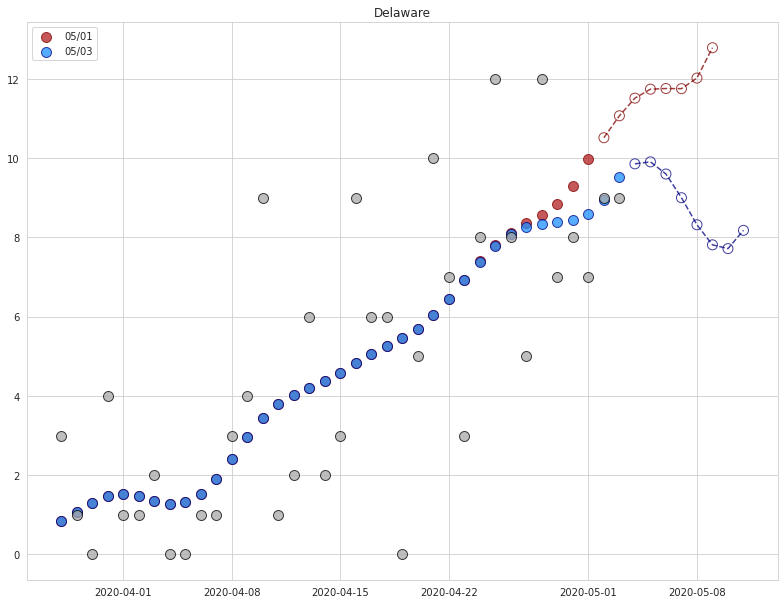

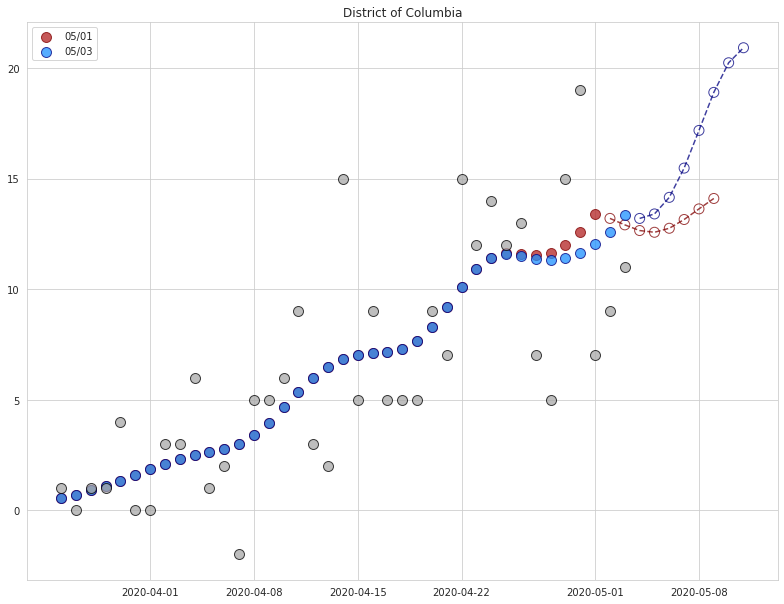

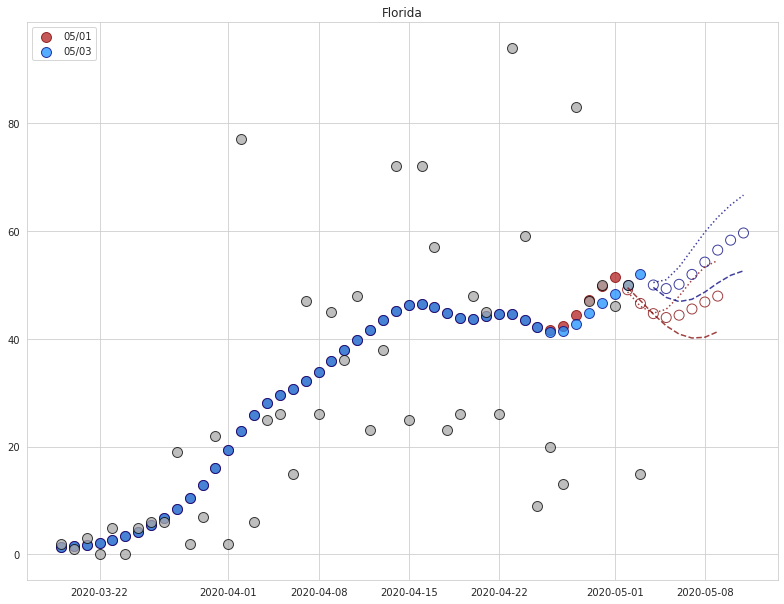

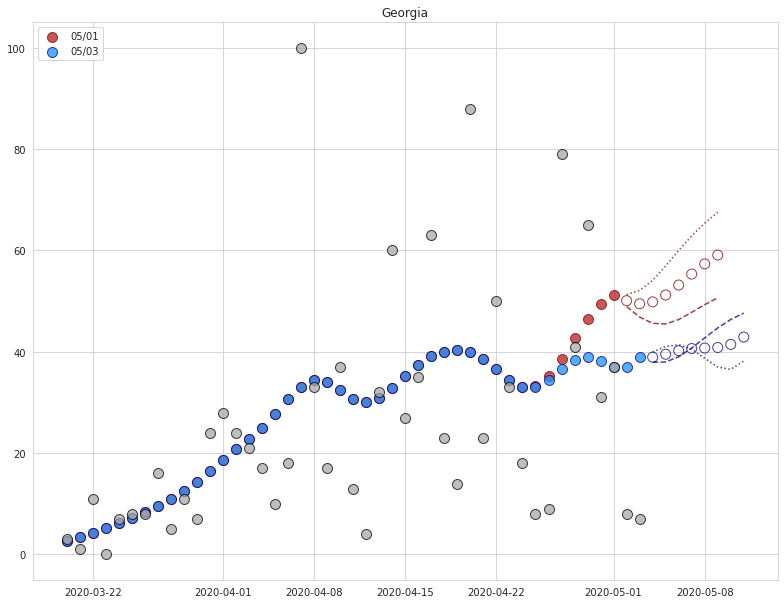

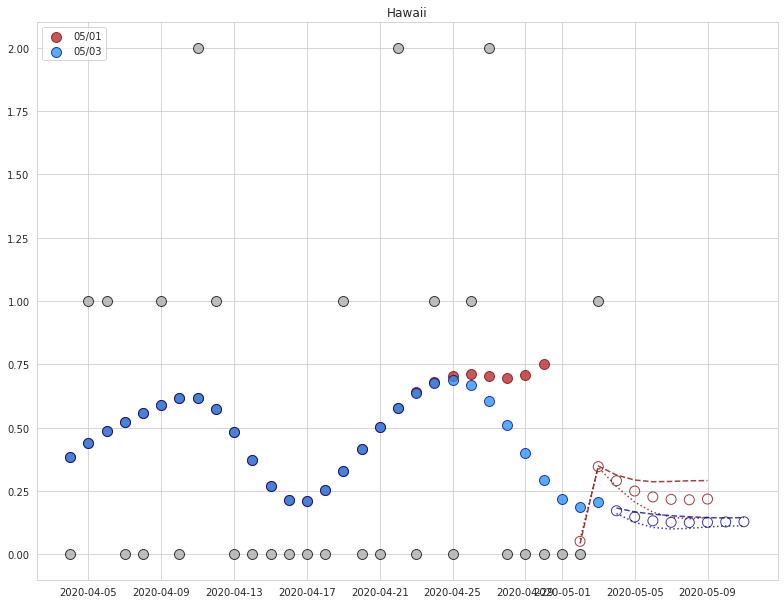

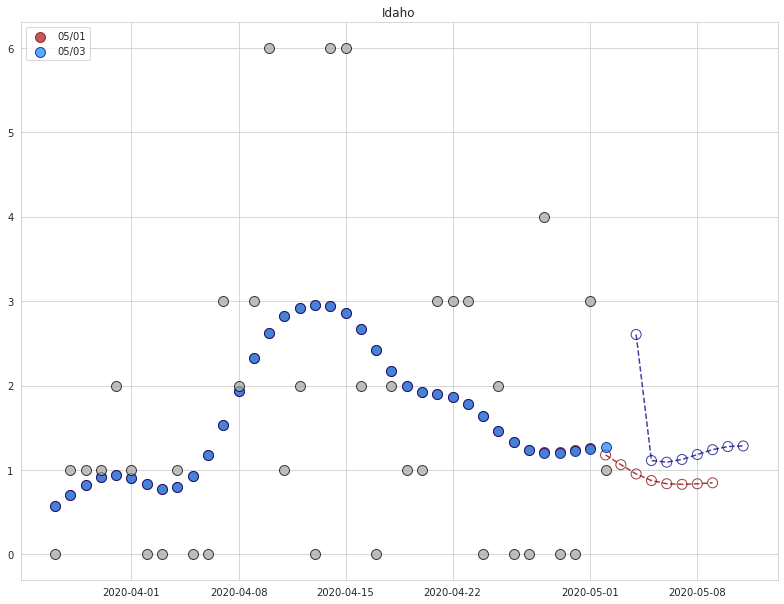

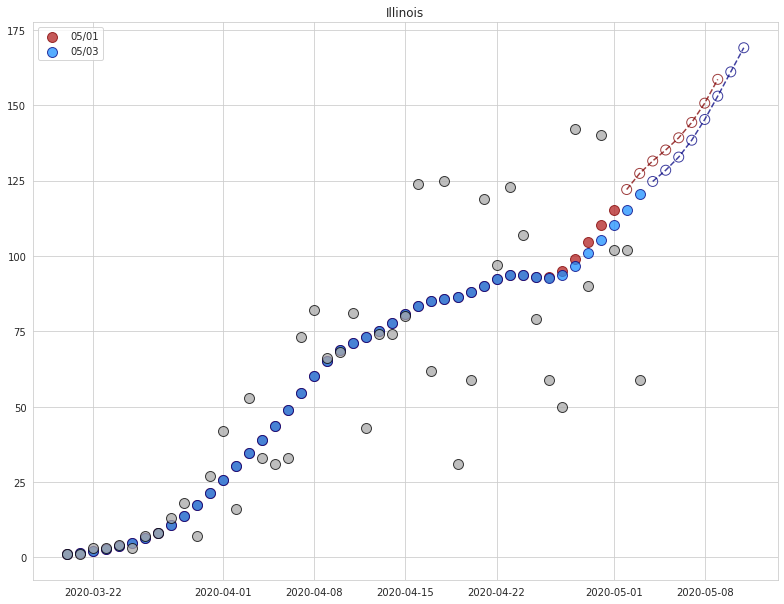

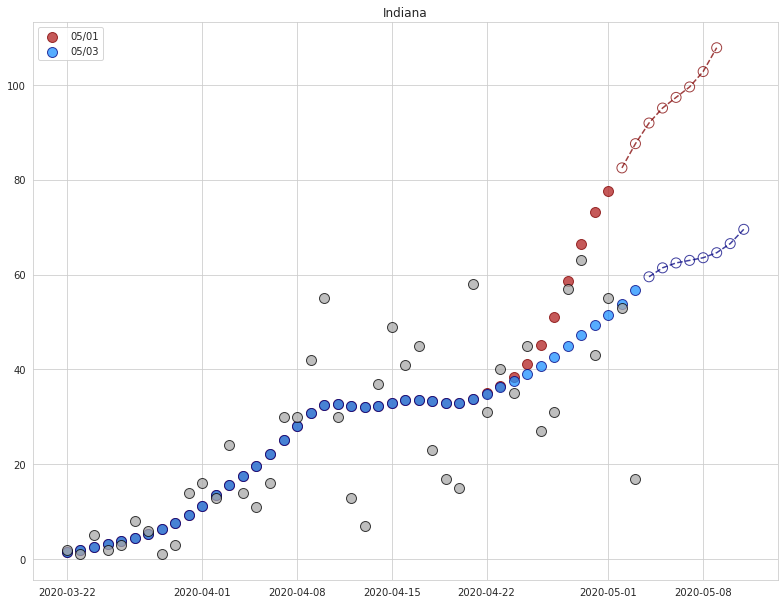

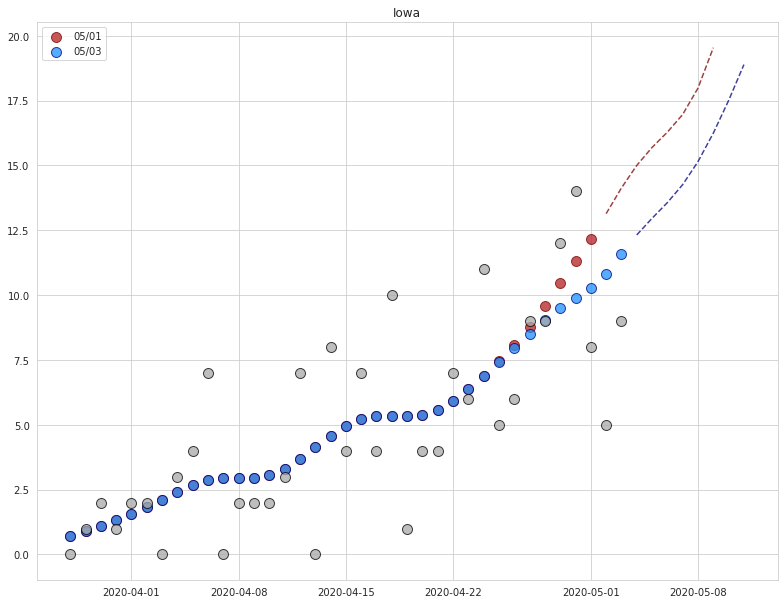

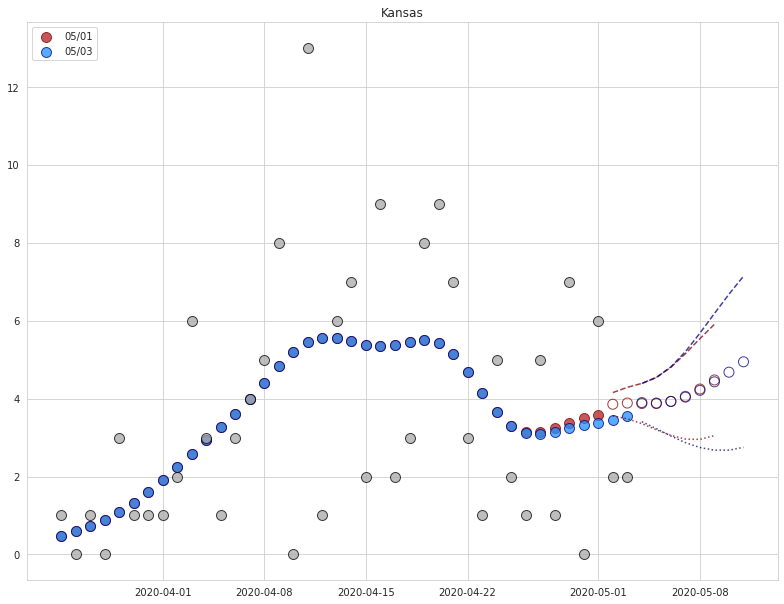

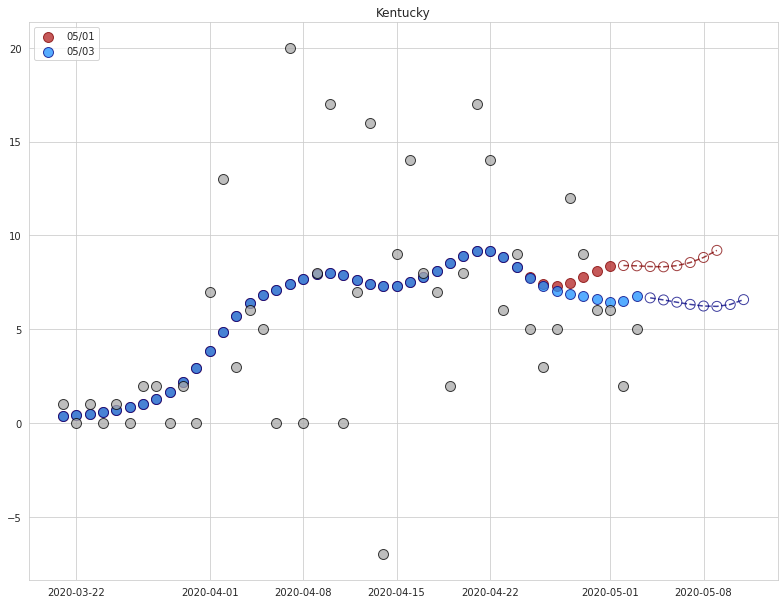

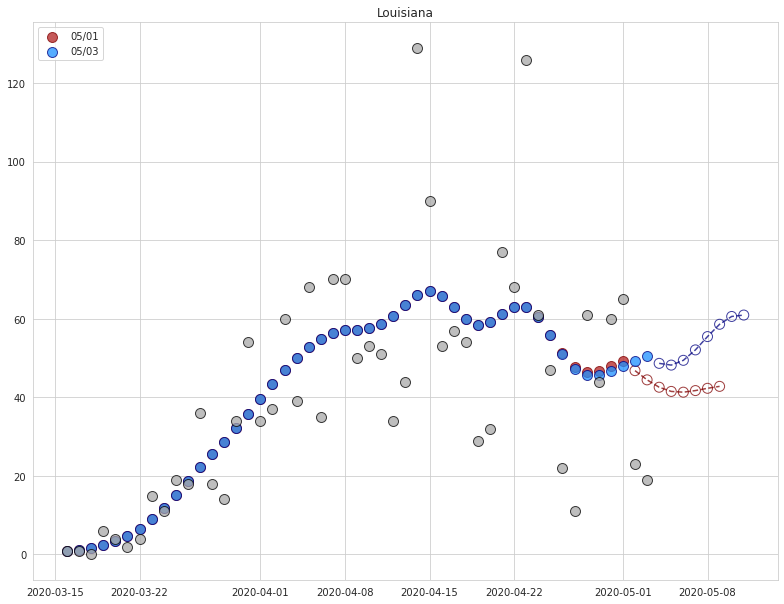

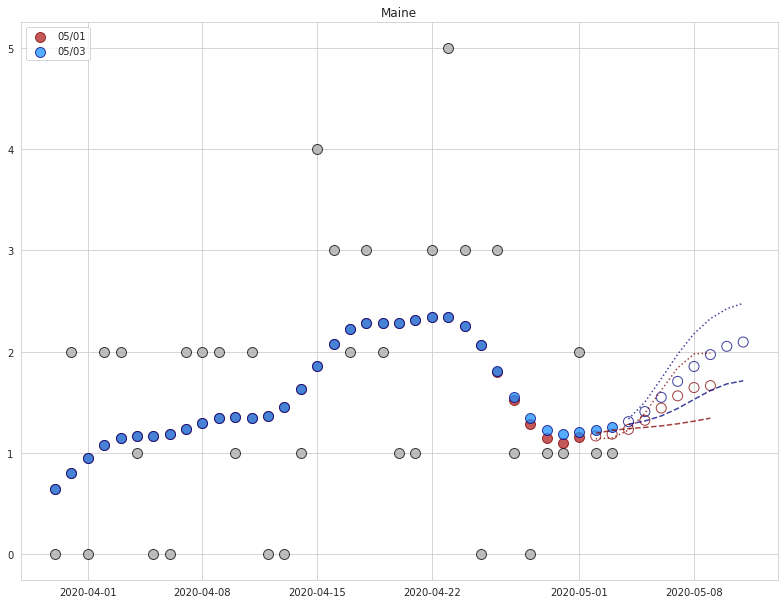

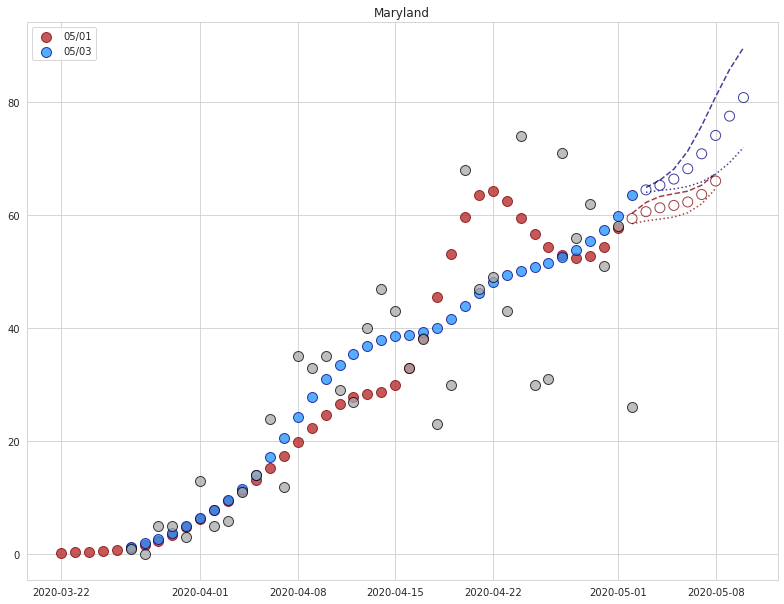

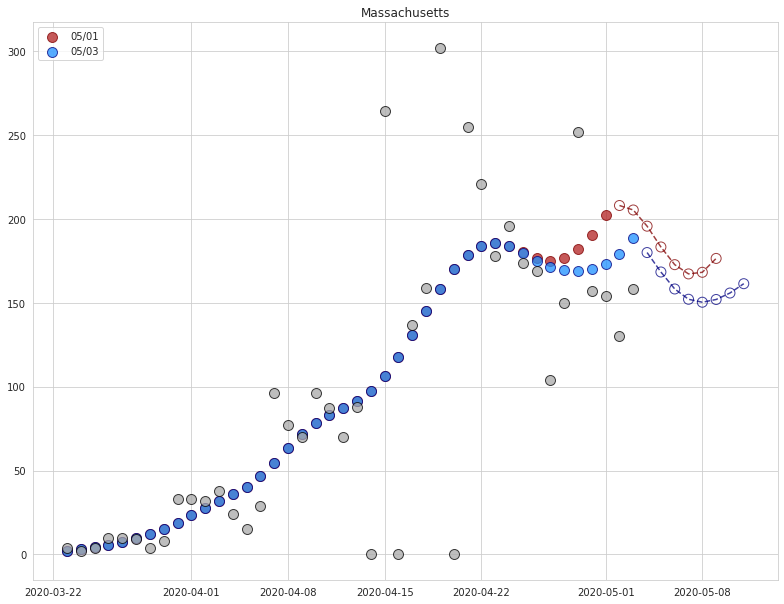

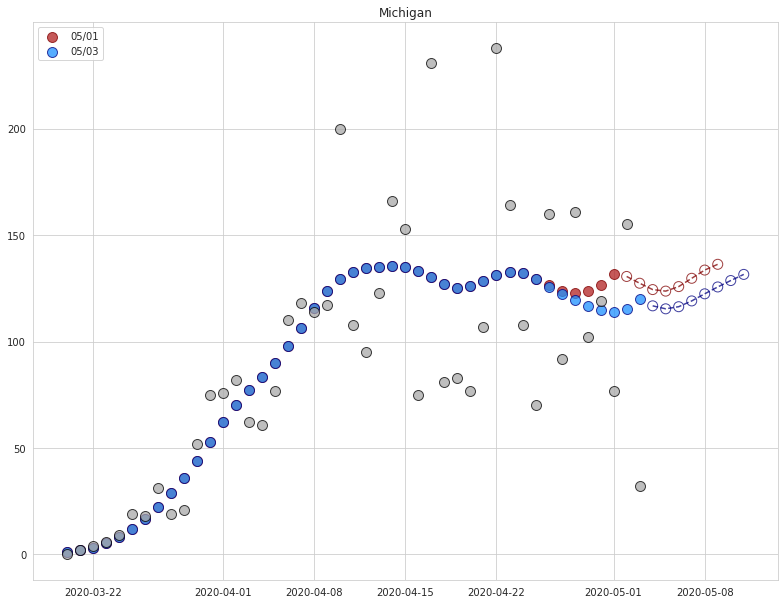

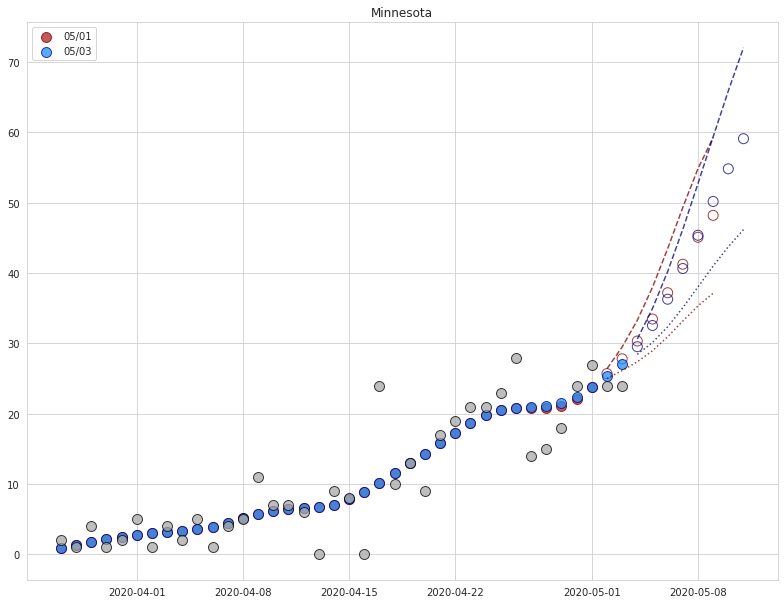

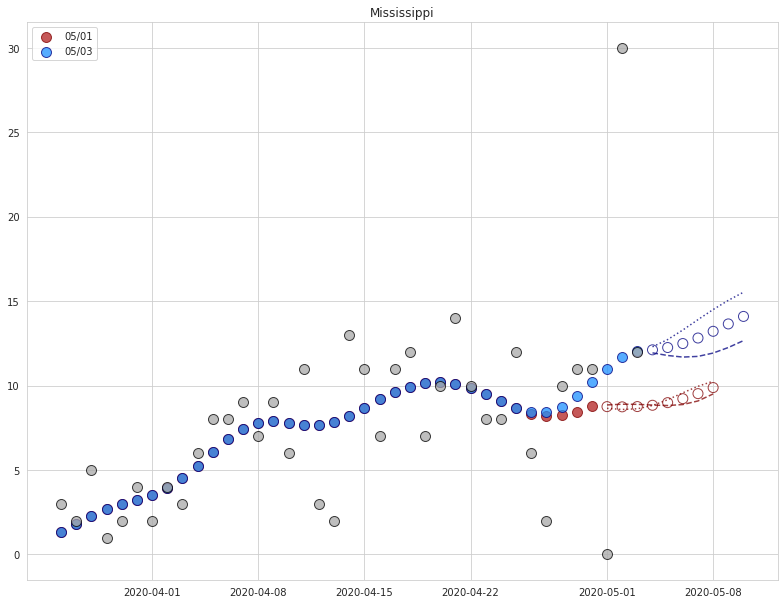

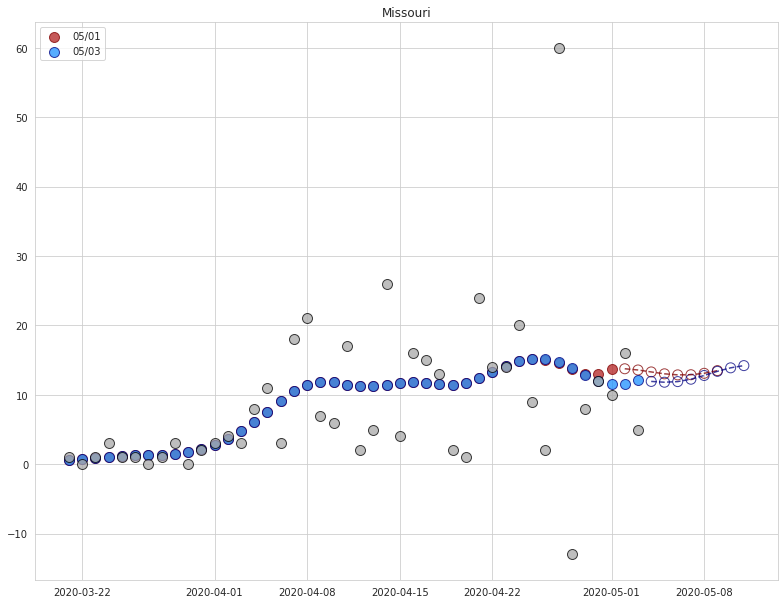

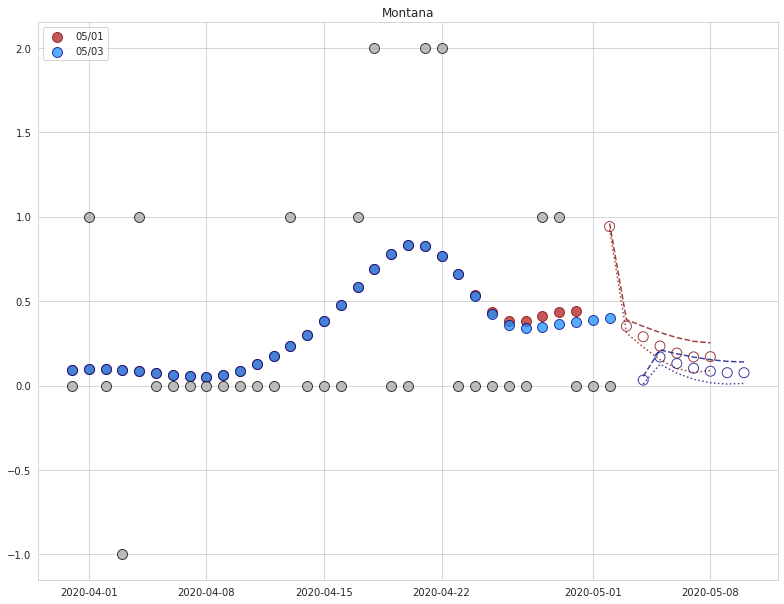

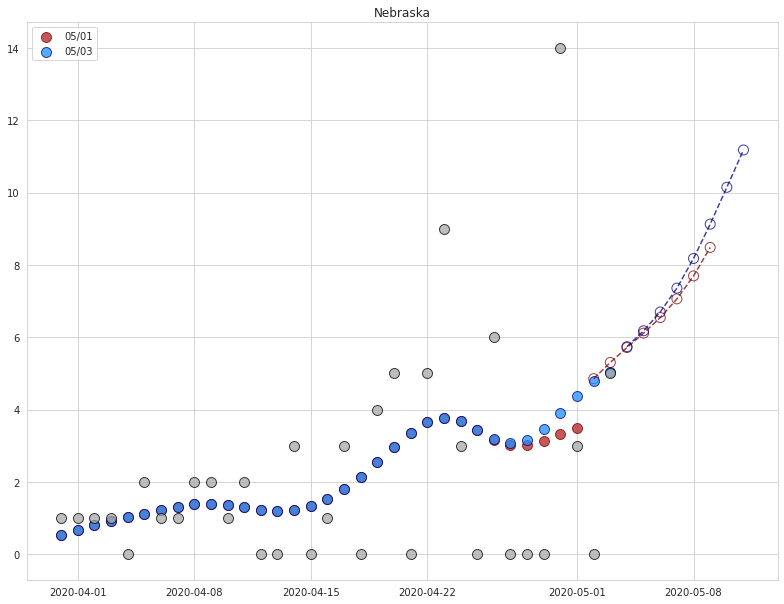

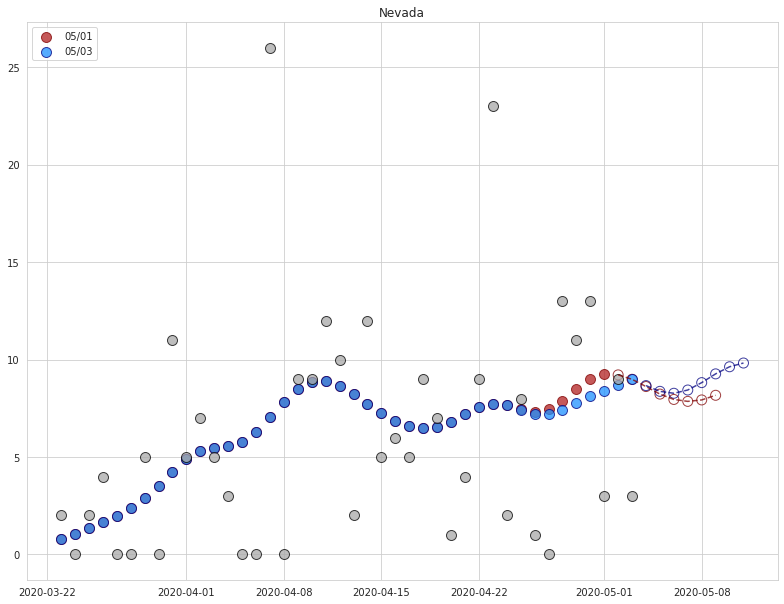

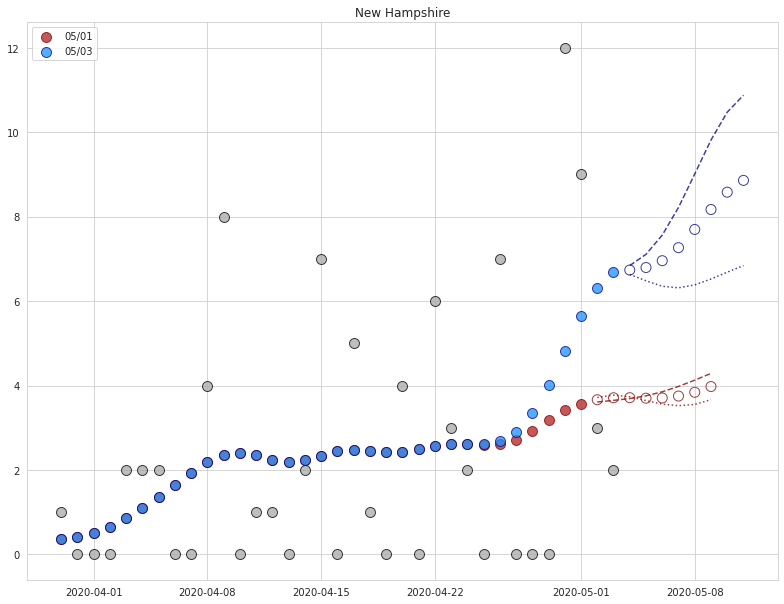

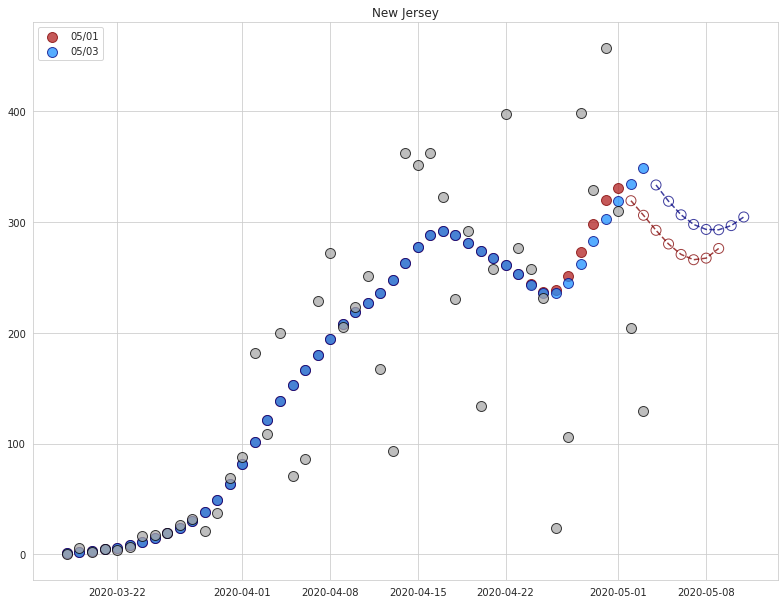

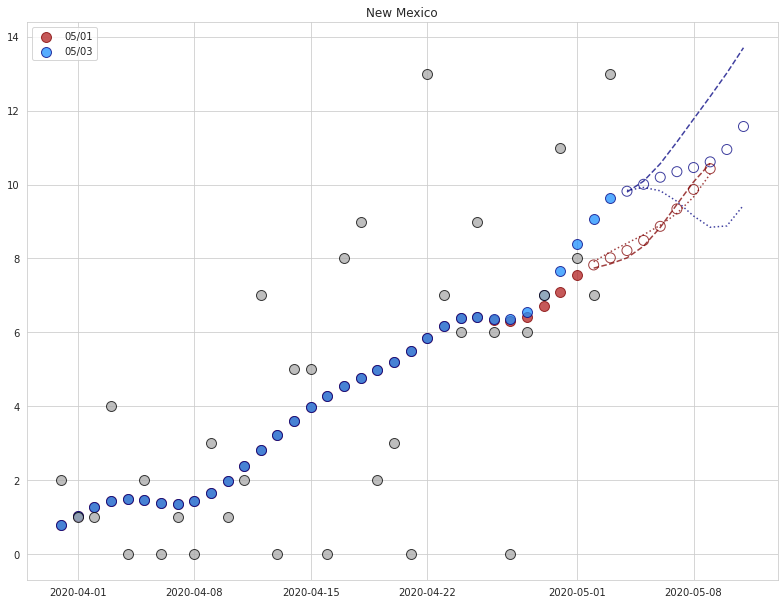

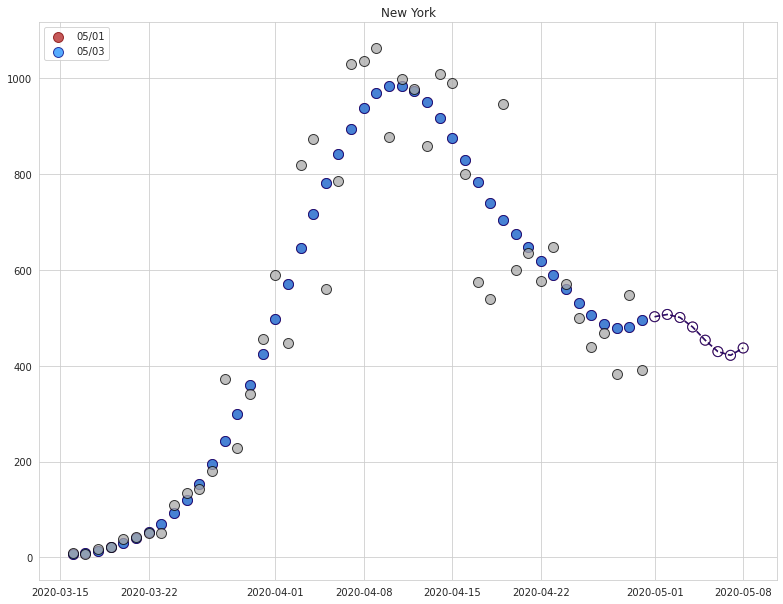

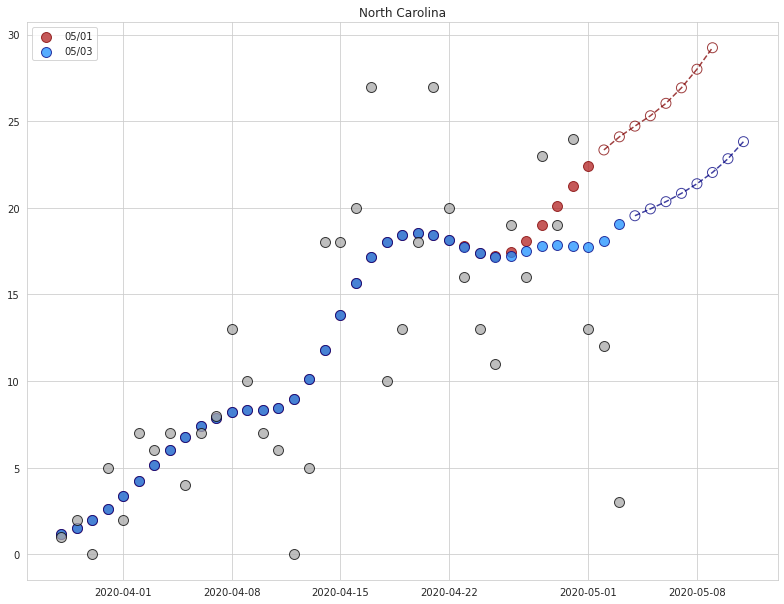

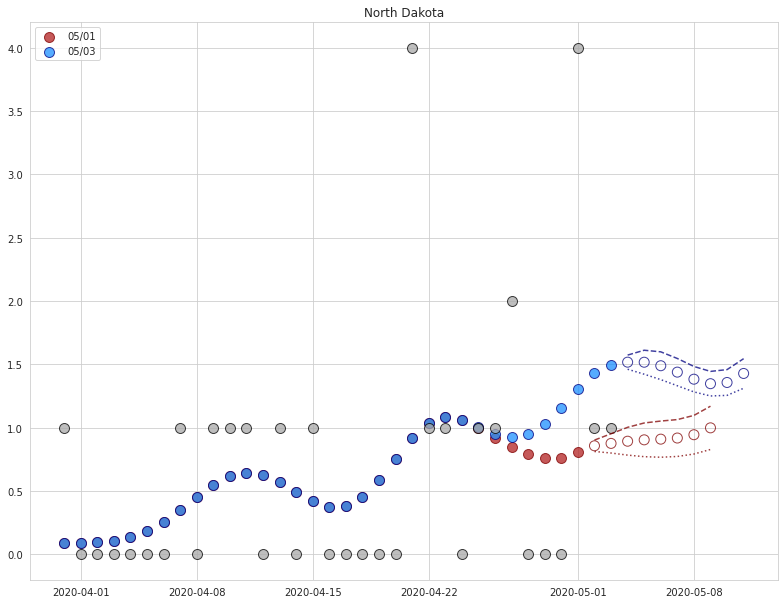

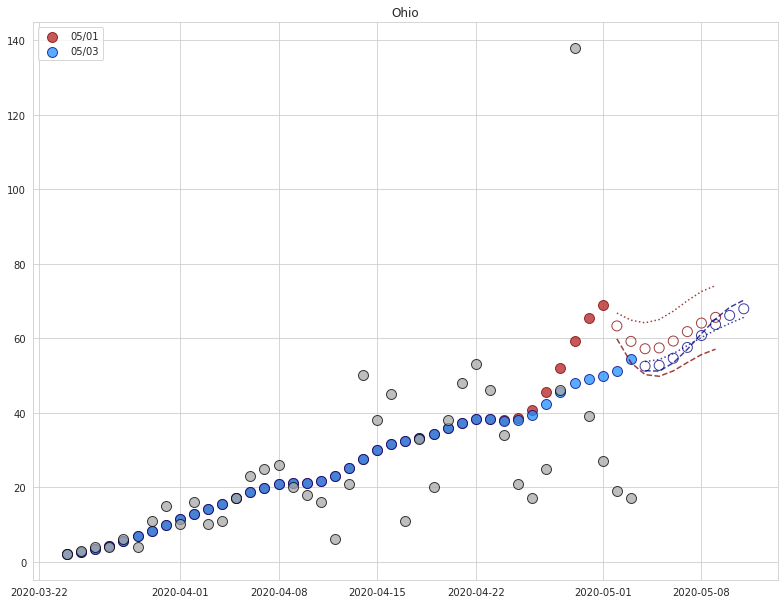

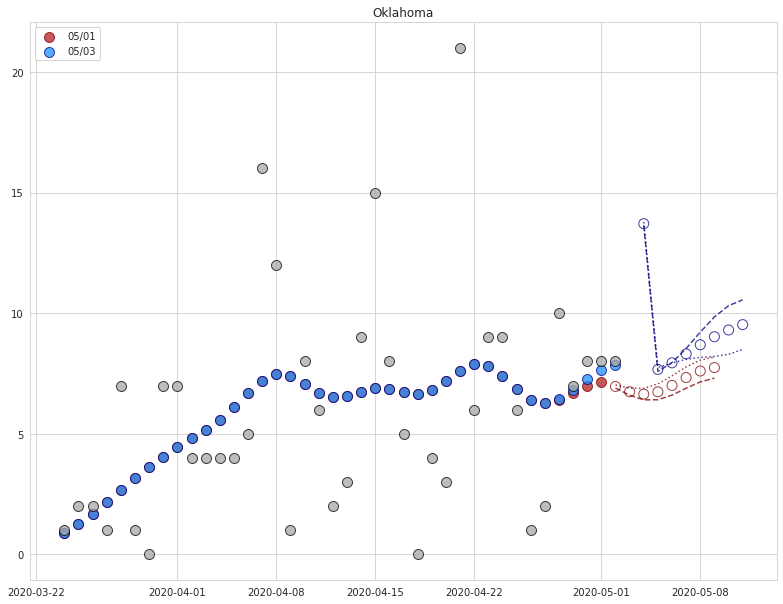

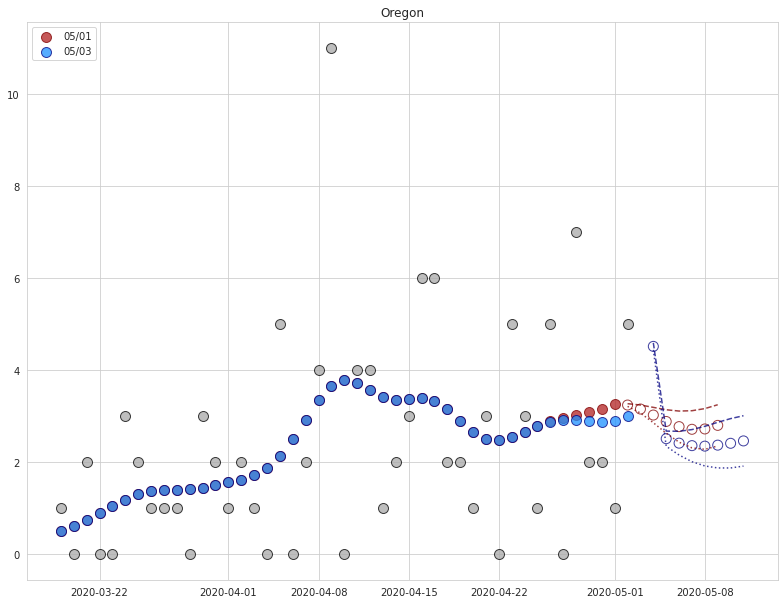

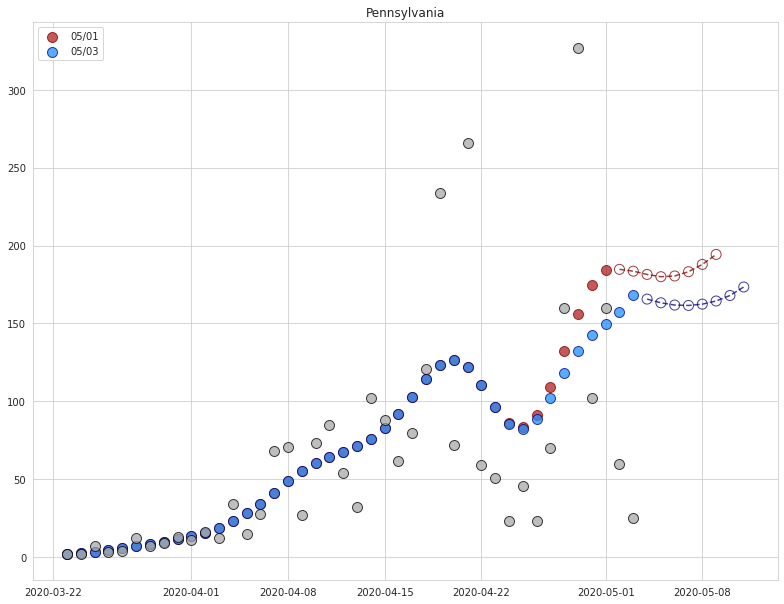

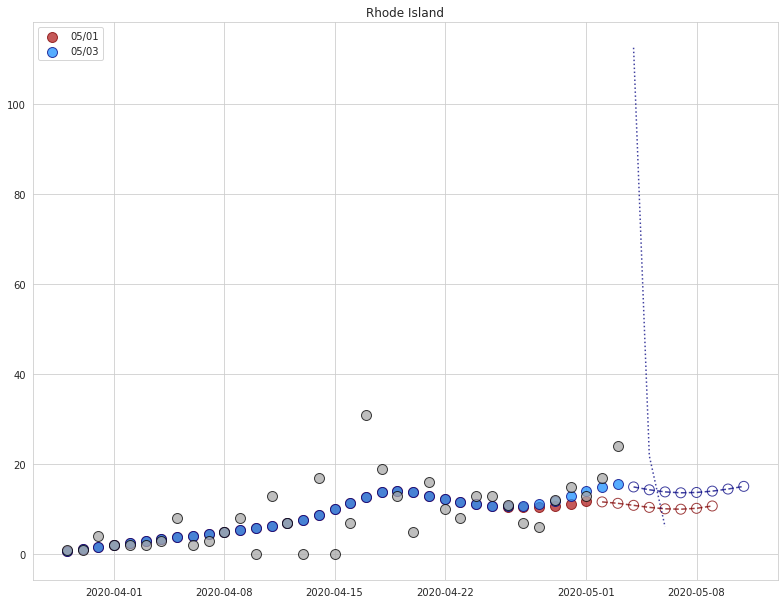

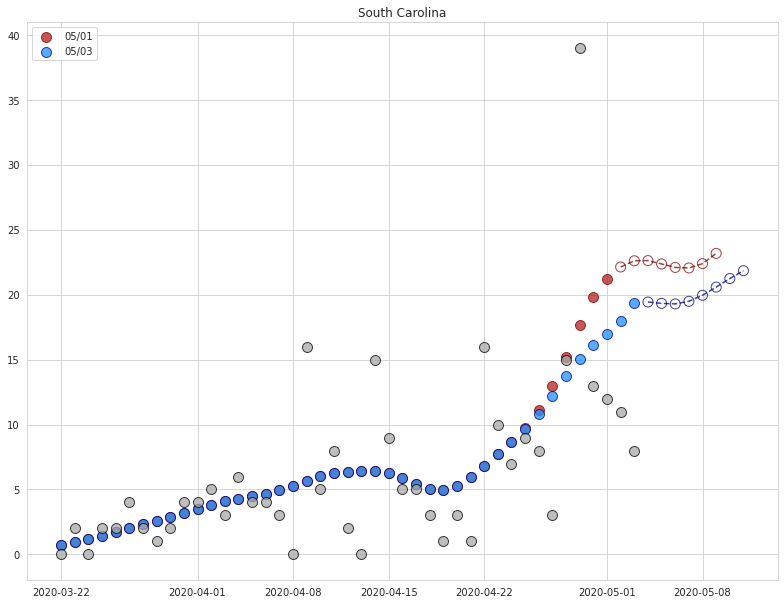

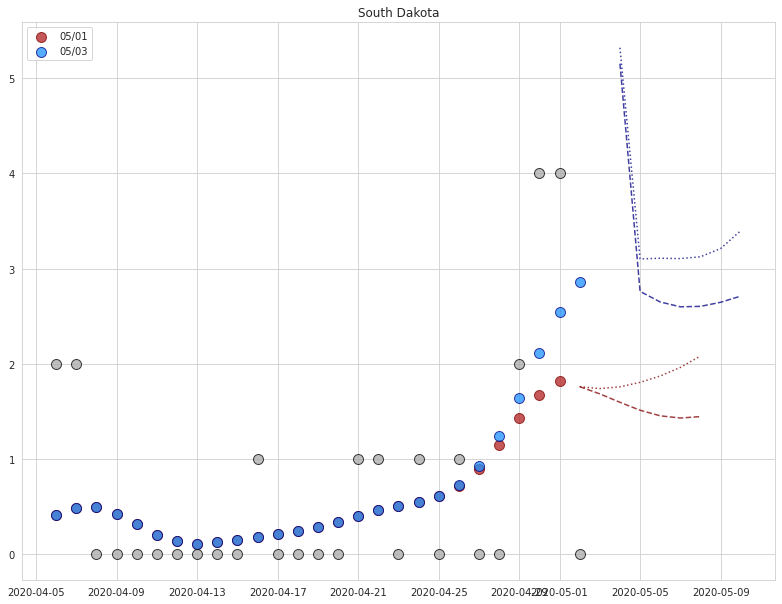

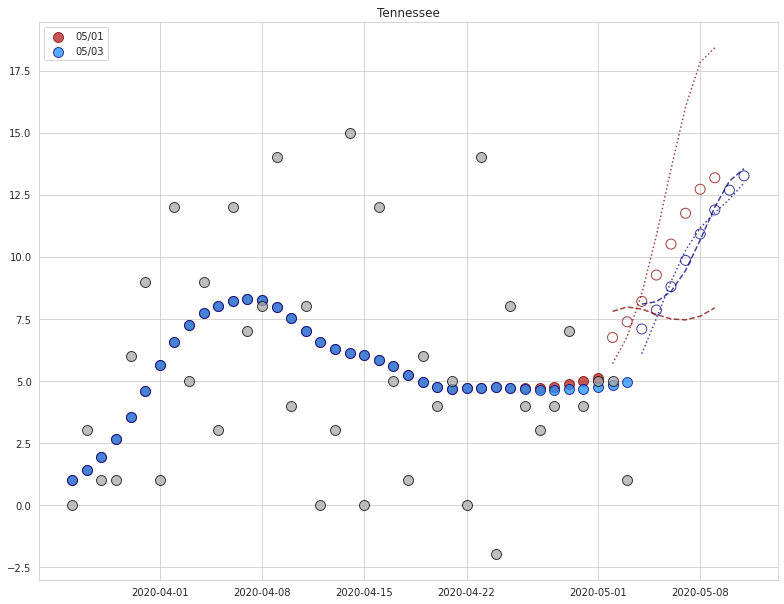

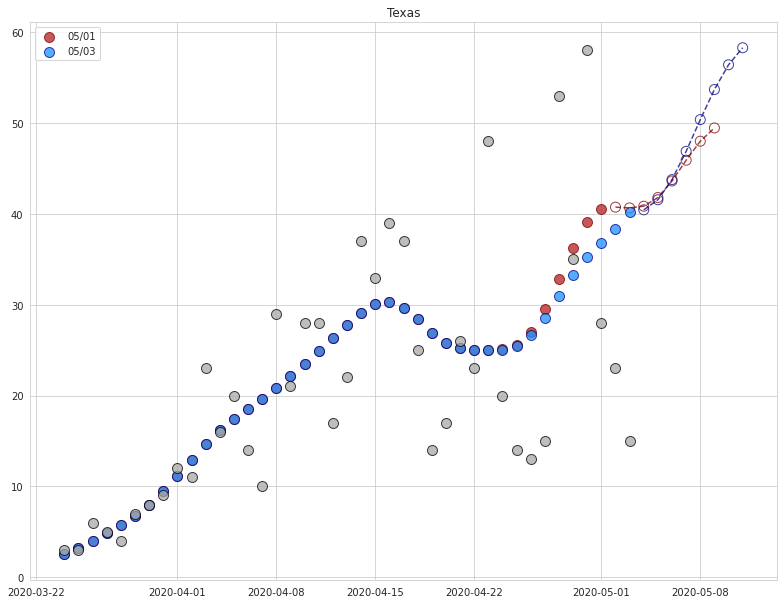

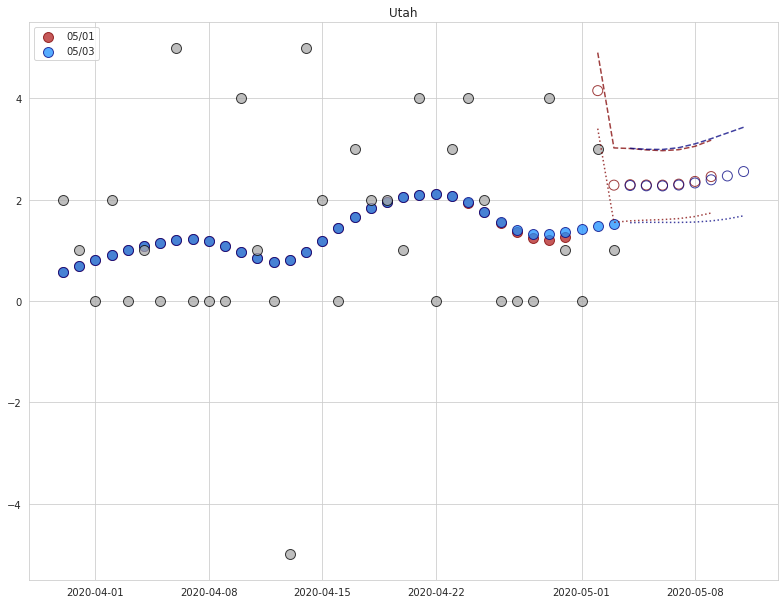

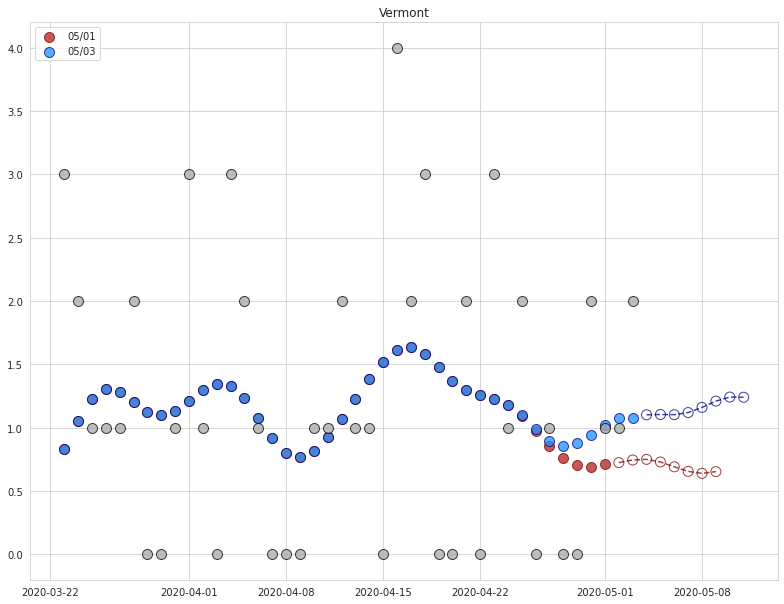

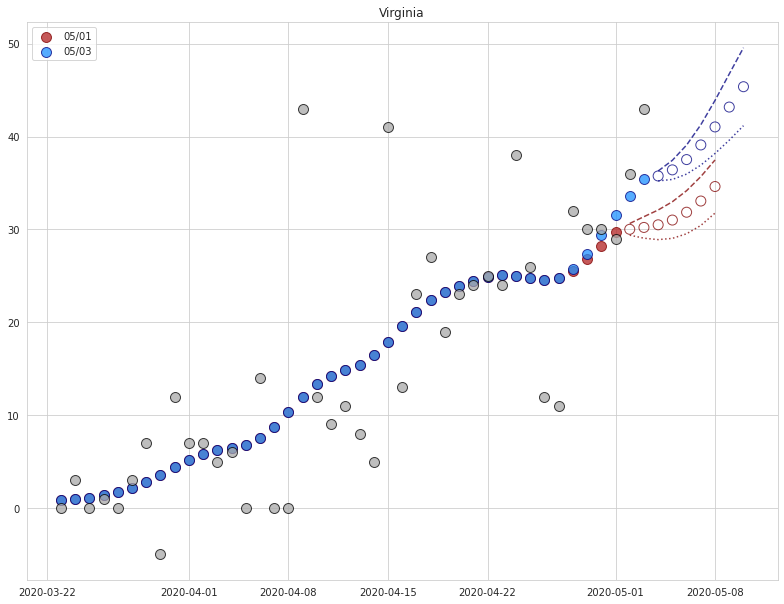

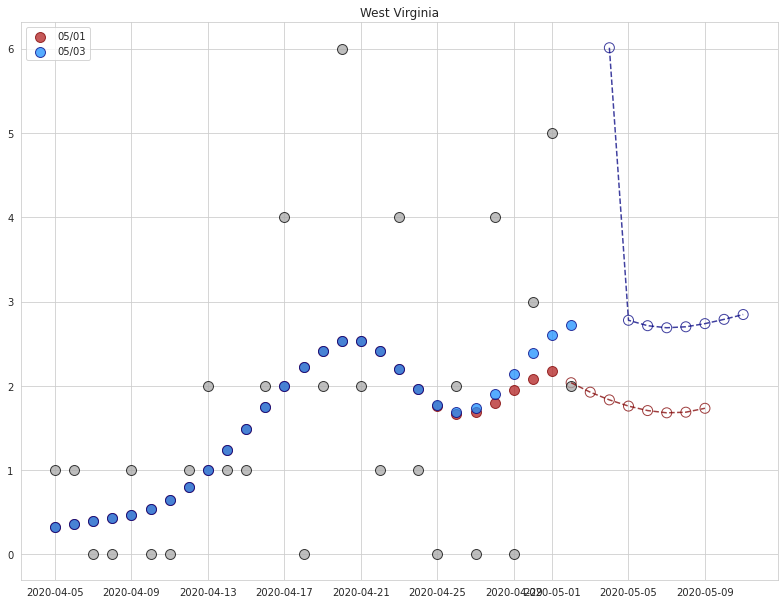

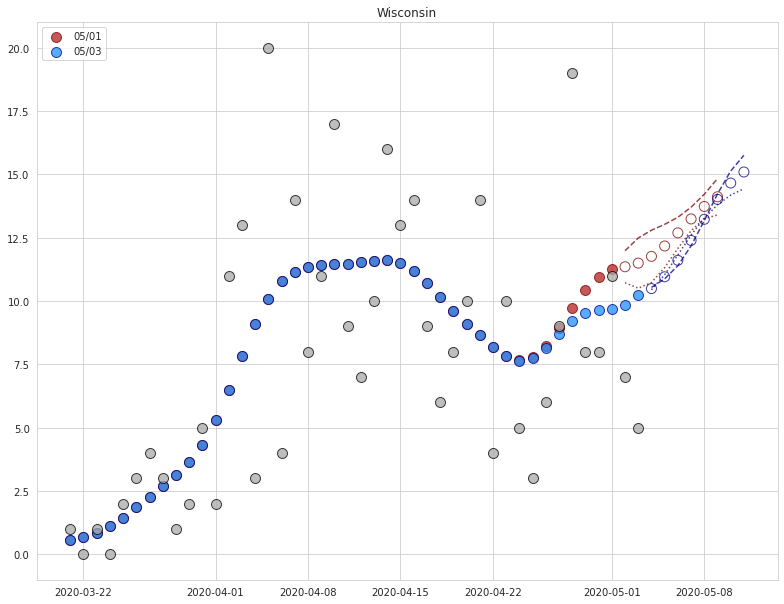

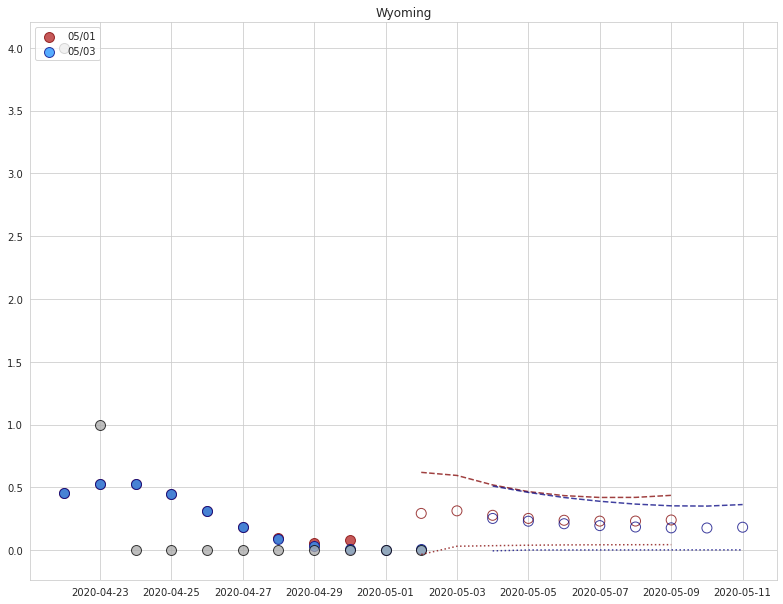

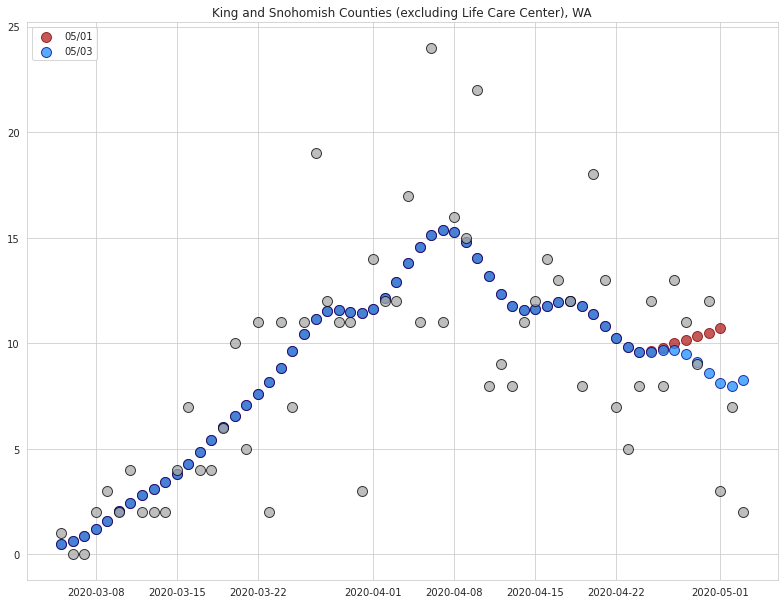

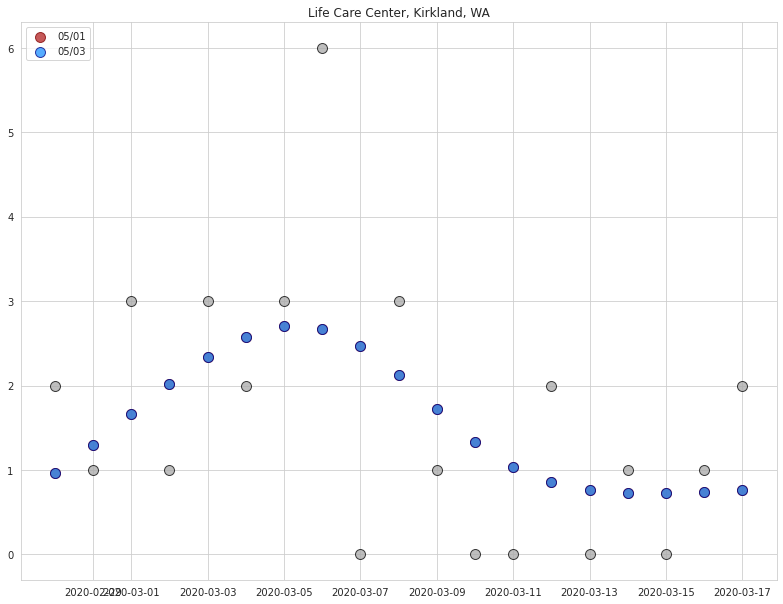

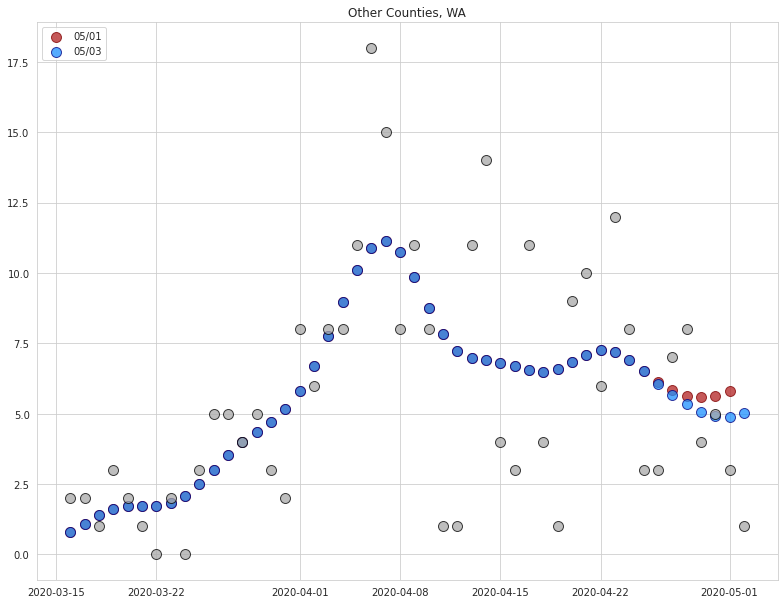

In [5]:
with PdfPages('/ihme/homes/rmbarber/covid-19/death_smoothing_0501_0503.pdf') as pdf:
    for location_id in location_ids:
        old_data = pd.read_csv(f'/ihme/covid-19/deaths/prod/2020_05_01_US_newmod/model_data_google_21/{location_id}.csv')
        old_data = old_data.loc[old_data['location_id'] == location_id].reset_index(drop=True)
        old_data['Date'] = pd.to_datetime(old_data['Date'])
        old_data['deaths'] = np.exp(old_data['ln(age-standardized death rate)']) * old_data['population']

        new_data = pd.read_csv(f'/ihme/covid-19/deaths/prod/2020_05_03_US/model_data_google_21/{location_id}.csv')
        new_data = new_data.loc[new_data['location_id'] == location_id].reset_index(drop=True)
        new_data['Date'] = pd.to_datetime(new_data['Date'])
        new_data['deaths'] = np.exp(new_data['ln(age-standardized death rate)']) * new_data['population']

        old_li_df = pd.read_csv('/ihme/covid-19/deaths/prod/2020_05_01_US_newmod/leading_indicator.csv')
        old_li_df = old_li_df.loc[old_li_df['location_id'] == location_id]
        old_li_df['Date'] = pd.to_datetime(old_li_df['Date'])
        old_li_df['from_cases'] = old_li_df['from_cases'] * old_data['population'][0]
        old_li_df['from_hospital'] = old_li_df['from_hospital'] * old_data['population'][0]
        from_cases = np.hstack([old_data[old_data['pseudo'] == 0].deaths.values[-1], old_li_df['from_cases'].values])
        old_li_df['from_cases'] = from_cases[1:] - from_cases[:-1]
        from_hospital = np.hstack([old_data[old_data['pseudo'] == 0].deaths.values[-1], old_li_df['from_hospital'].values])
        old_li_df['from_hospital'] = from_hospital[1:] - from_hospital[:-1]

        new_li_df = pd.read_csv('/ihme/covid-19/deaths/prod/2020_05_03_US/leading_indicator.csv')
        new_li_df = new_li_df.loc[new_li_df['location_id'] == location_id]
        new_li_df['Date'] = pd.to_datetime(new_li_df['Date'])
        new_li_df['from_cases'] = new_li_df['from_cases'] * new_data['population'][0]
        new_li_df['from_hospital'] = new_li_df['from_hospital'] * new_data['population'][0]
        from_cases = np.hstack([new_data[new_data['pseudo'] == 0].deaths.values[-1], new_li_df['from_cases'].values])
        new_li_df['from_cases'] = from_cases[1:] - from_cases[:-1]
        from_hospital = np.hstack([new_data[new_data['pseudo'] == 0].deaths.values[-1], new_li_df['from_hospital'].values])
        new_li_df['from_hospital'] = from_hospital[1:] - from_hospital[:-1]


        plt.figure(figsize=(11, 8.5))
        old_pseudo = (old_data['pseudo'] == 1).values[1:]
        plt.scatter(old_data['Date'][1:][~old_pseudo],
                    (old_data['deaths'].values[1:] - old_data['deaths'].values[:-1])[~old_pseudo],
                    c='firebrick', edgecolors='maroon', s=100, alpha=0.75, label='05/01')
        plt.scatter(old_data['Date'][1:][old_pseudo],
                    (old_data['deaths'].values[1:] - old_data['deaths'].values[:-1])[old_pseudo],
                    c='none', edgecolors='maroon', s=100, alpha=0.75)
        plt.plot(old_li_df['Date'],
                old_li_df['from_cases'],
                c='maroon', linestyle='--', alpha=0.75)
        plt.plot(old_li_df['Date'],
                old_li_df['from_hospital'],
                c='maroon', linestyle=':', alpha=0.75)

        new_pseudo = (new_data['pseudo'] == 1).values[1:]
        plt.scatter(new_data['Date'][1:][~new_pseudo],
                    (new_data['deaths'].values[1:] - new_data['deaths'].values[:-1])[~new_pseudo],
                    c='dodgerblue', edgecolors='navy', s=100, alpha=0.75, label='05/03')
        plt.scatter(new_data['Date'][1:],
                    (new_data['Deaths'].values[1:] - new_data['Deaths'].values[:-1]),
                    c='darkgrey', edgecolors='black', s=100, alpha=0.75)
        plt.scatter(new_data['Date'][1:][new_pseudo],
                    (new_data['deaths'].values[1:] - new_data['deaths'].values[:-1])[new_pseudo],
                    c='none', edgecolors='navy', s=100, alpha=0.75)
        plt.plot(new_li_df['Date'],
                new_li_df['from_cases'],
                c='navy', linestyle='--', alpha=0.75)
        plt.plot(new_li_df['Date'],
                new_li_df['from_hospital'],
                c='navy', linestyle=':', alpha=0.75)
        plt.legend(loc=2)
        plt.title(new_data['Location'][0])
        plt.tight_layout()
        pdf.savefig()


In [ ]:
    # tsmooth = np.exp(new_data['Observed ln(age-standardized death rate)'].rolling(13, 
    #                                                                      min_periods=5, 
    #                                                                      win_type='triang',
    #                                                                      center=True).mean()) * \
    #     new_data['population']
    # plt.scatter(new_data['Date'][1:],
    #             tsmooth.values[1:] - tsmooth.values[:-1],
    #             c='black', marker='x', s=100, alpha=0.75)


In [ ]:
old_dcr = pd.read_csv(f'/ihme/covid-19/deaths/prod/2020_05_01_US_newmod/lagged_death_to_case_ratios.csv')
old_dcr = old_dcr.rename(index=str, columns={'dcr lag8':'old_ratio'})
new_dcr = pd.read_csv(f'/ihme/covid-19/deaths/prod/2020_05_03_US/lagged_death_to_case_ratios.csv')
new_dcr = new_dcr.rename(index=str, columns={'dcr lag8':'new_ratio'})
dcr = old_dcr.merge(new_dcr)

dcr = dcr[~dcr.isnull().any(axis=1)]

dcr = dcr.set_index('location_id')
plotmin = dcr.values.min()
plotmax = dcr.values.max()

plt.scatter(dcr['old_ratio'], dcr['new_ratio'])
plt.plot((plotmin, plotmax), (plotmin, plotmax))
plt.show()
print(dcr.loc[location_id])

ark_df = pd.read_csv('/ihme/covid-19/deaths/prod/2020_05_03_US/model_data_google_21/526.csv')
ark_df = ark_df.loc[ark_df['location_id'] == 526]

ark_df['Smoothed deaths'] = np.exp(ark_df['ln(age-standardized death rate)']) * ark_df['population']
ark_df[['Date', 'Deaths', 'Smoothed deaths']]


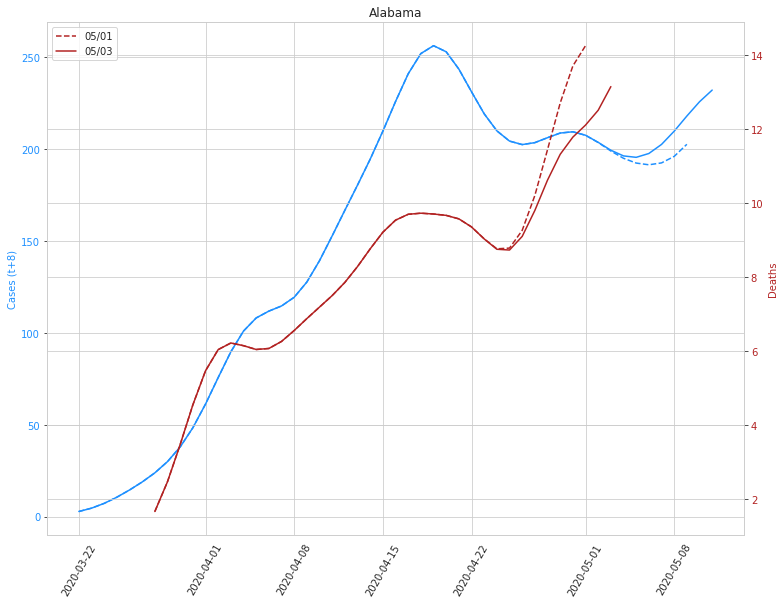

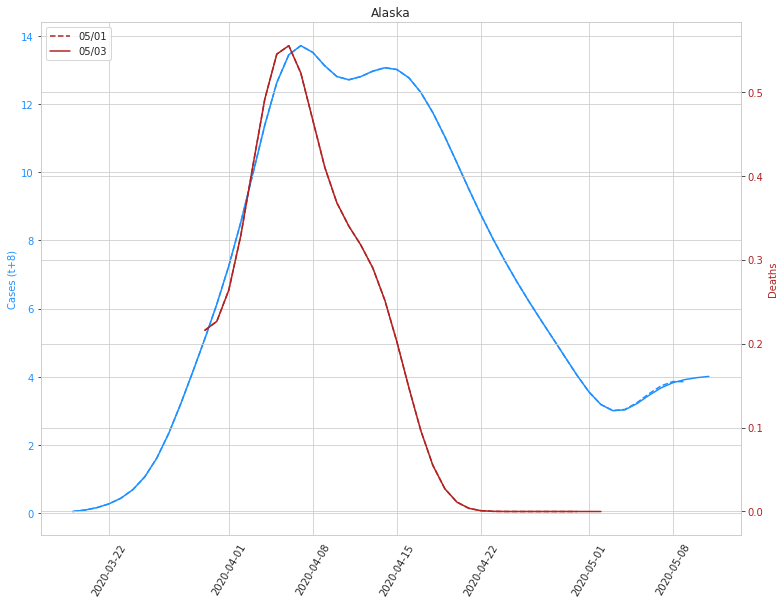

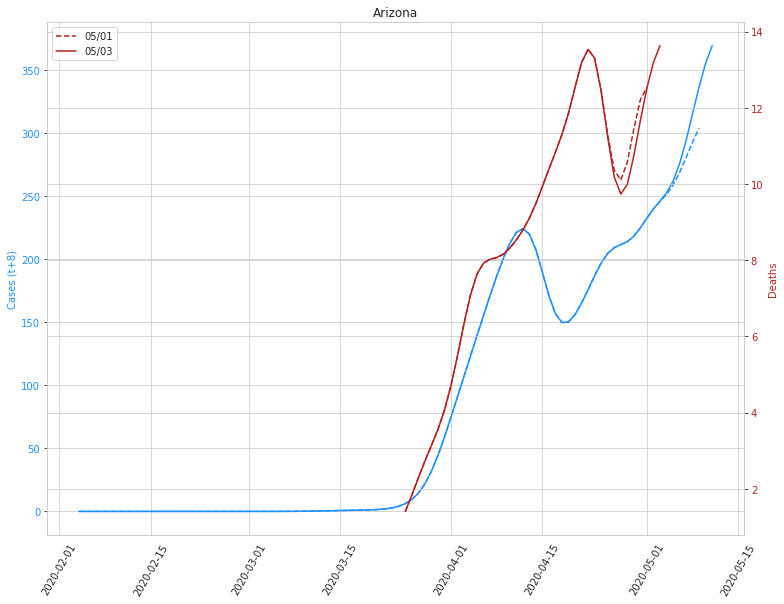

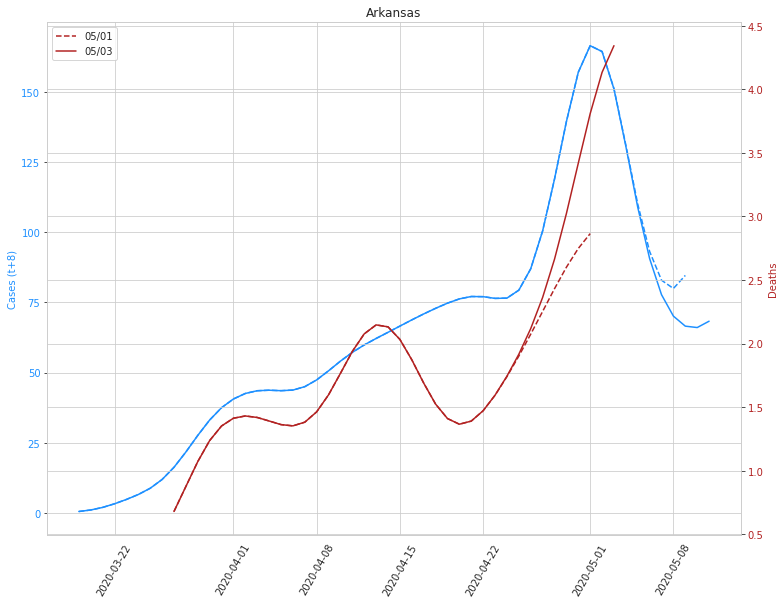

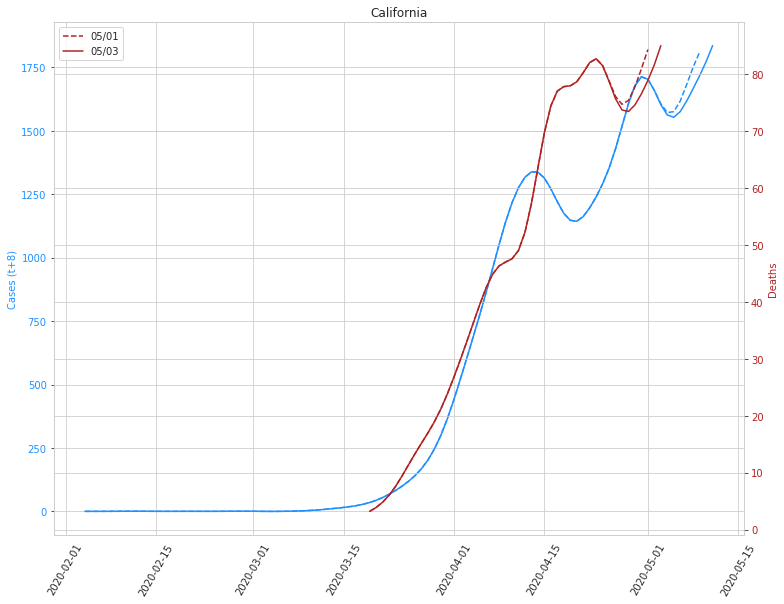

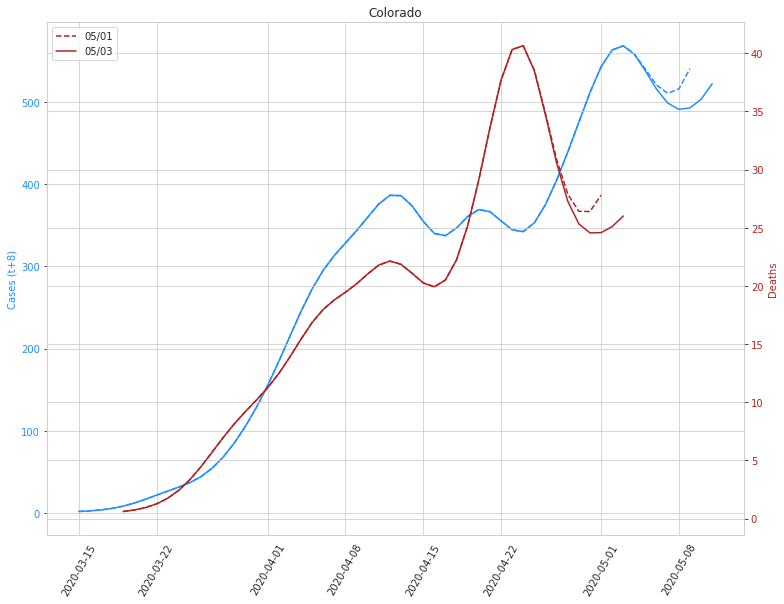

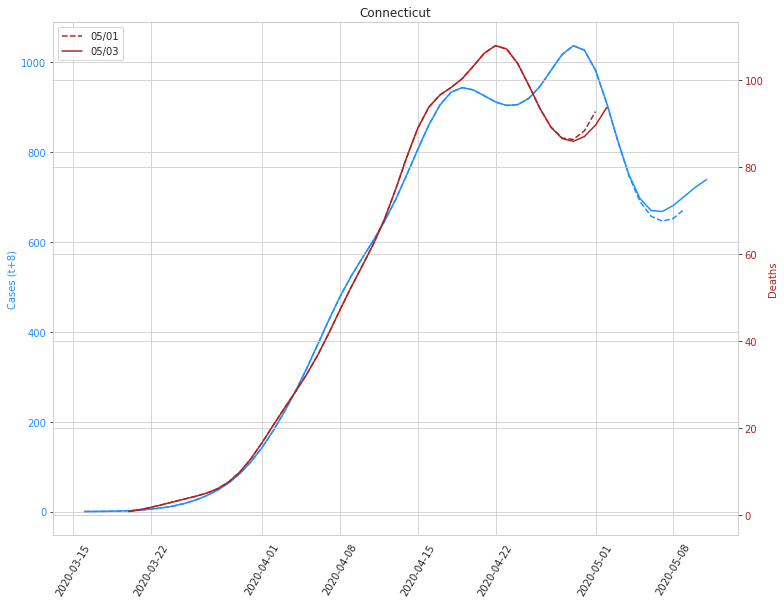

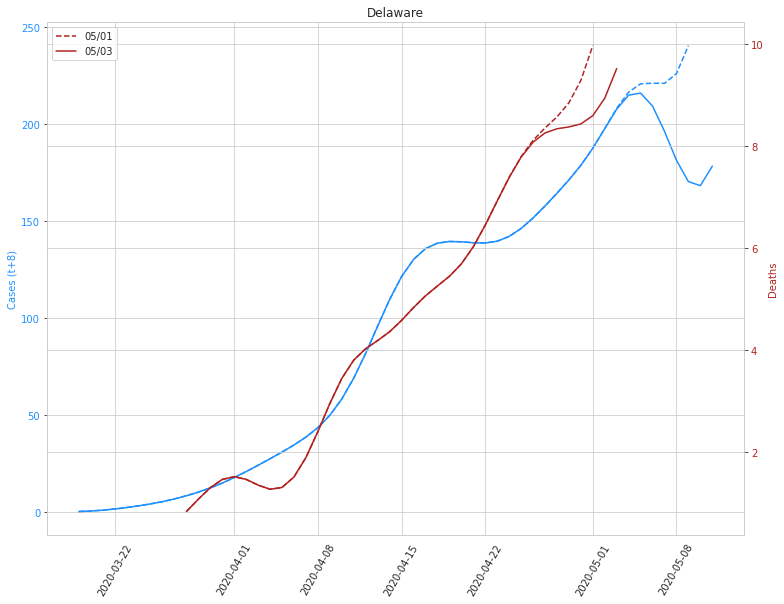

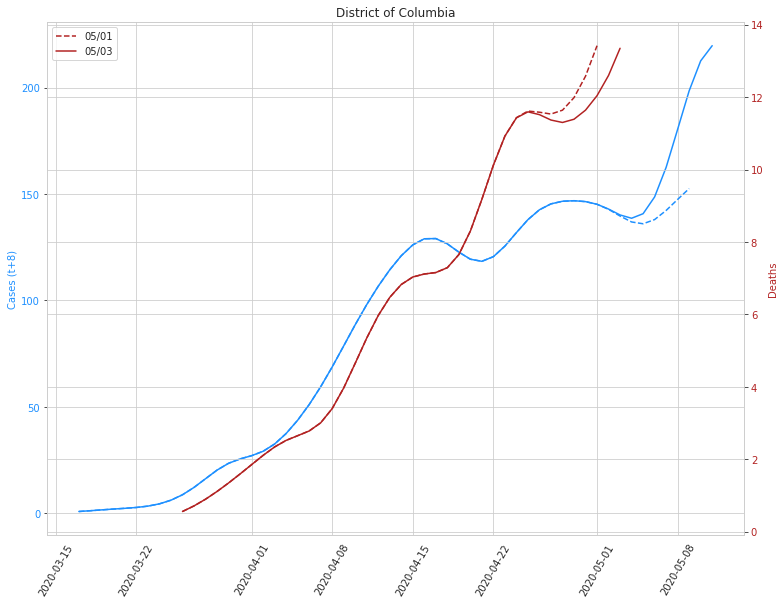

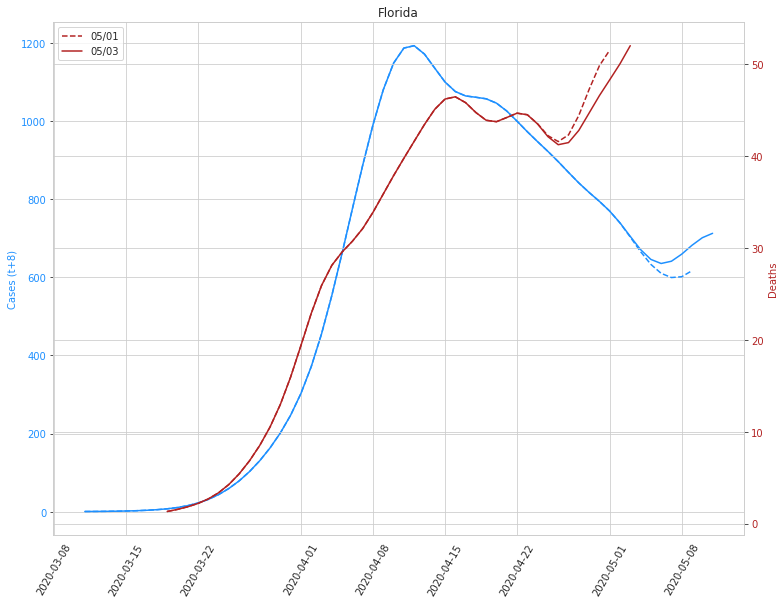

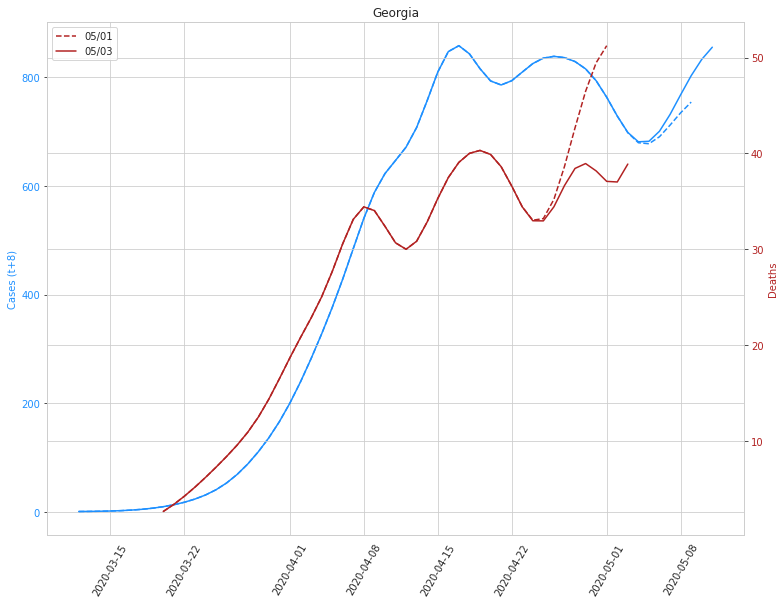

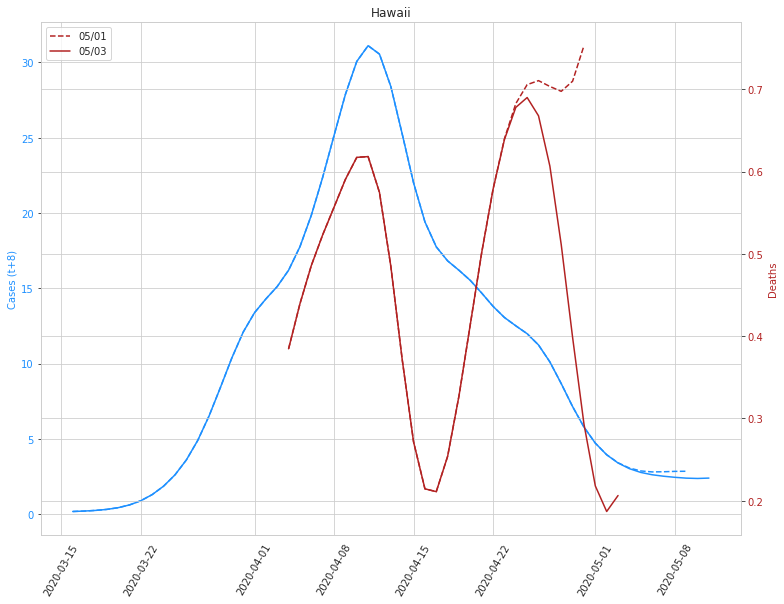

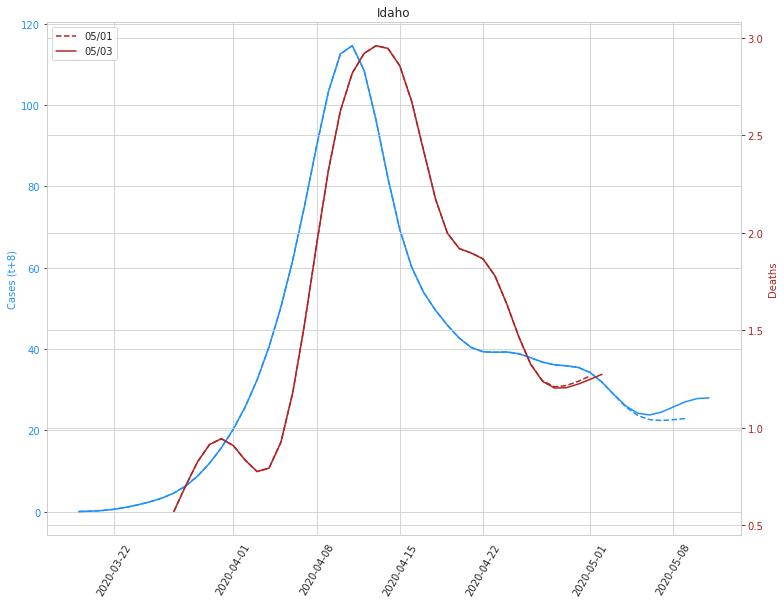

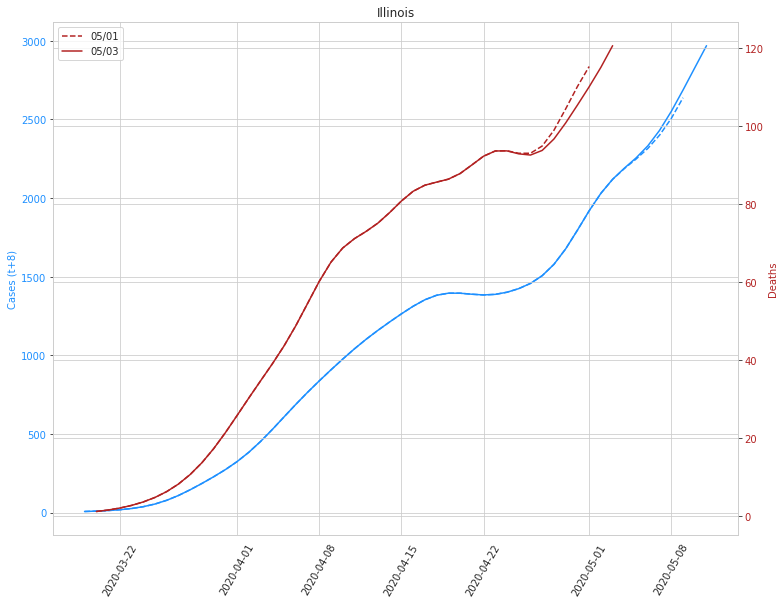

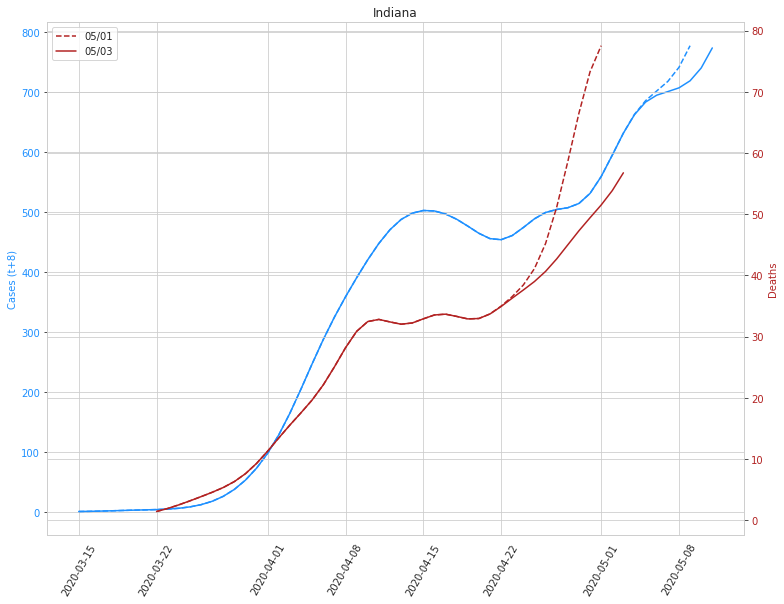

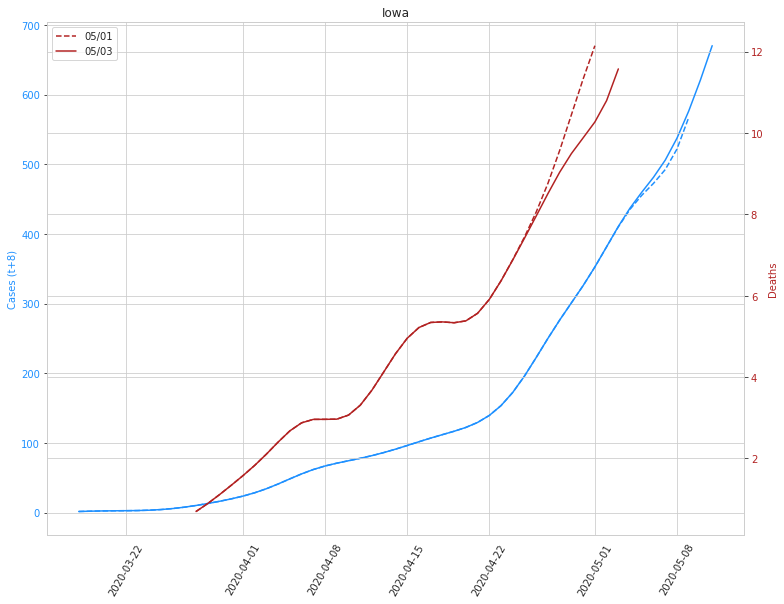

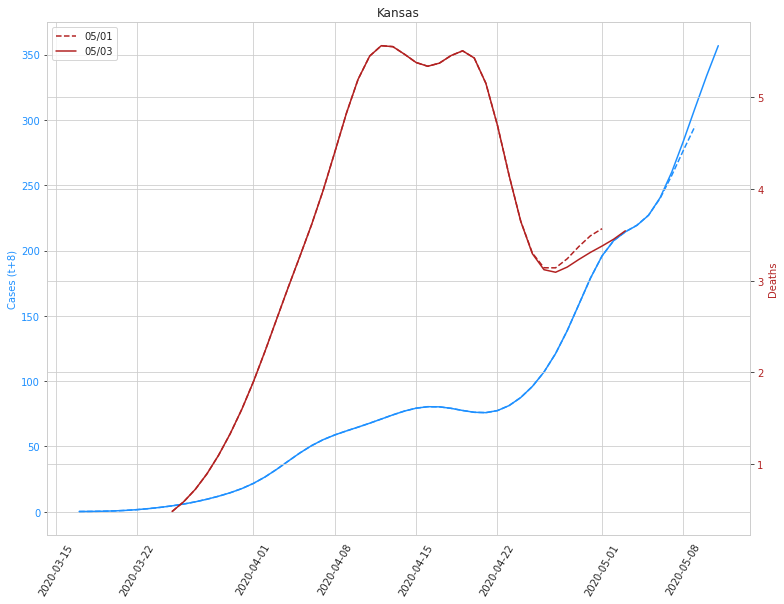

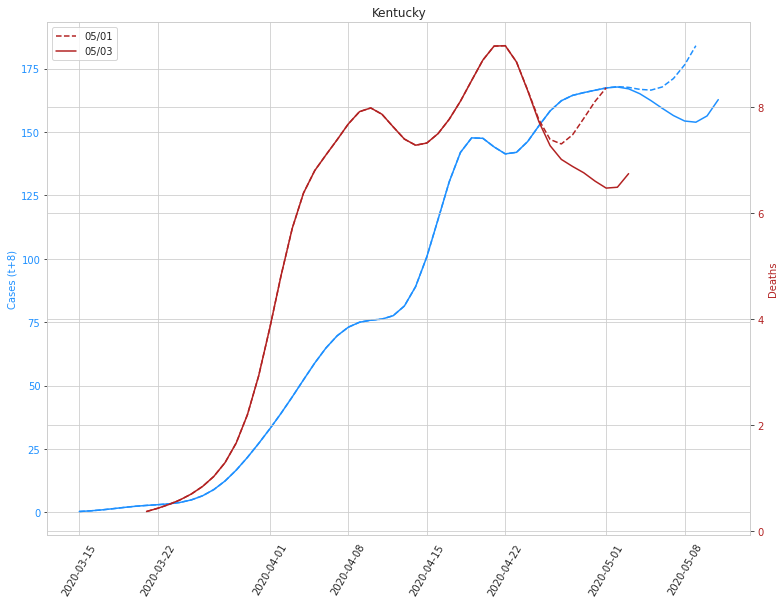

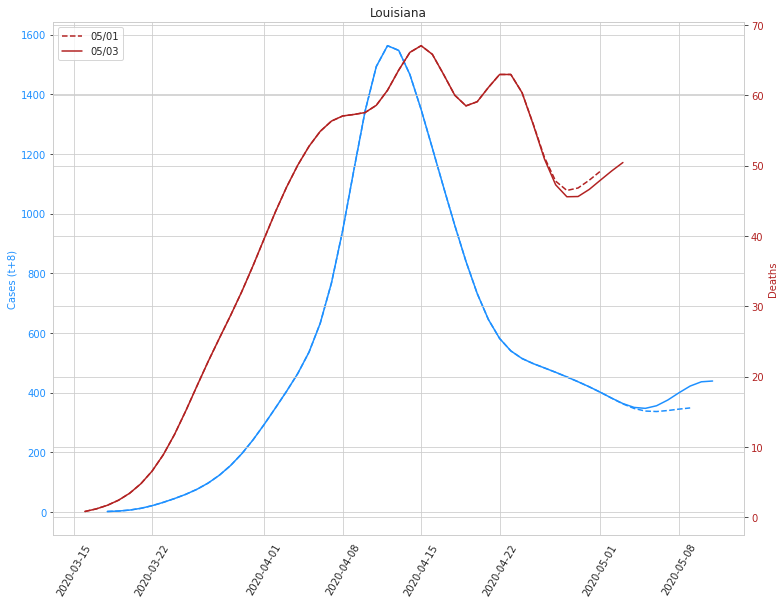

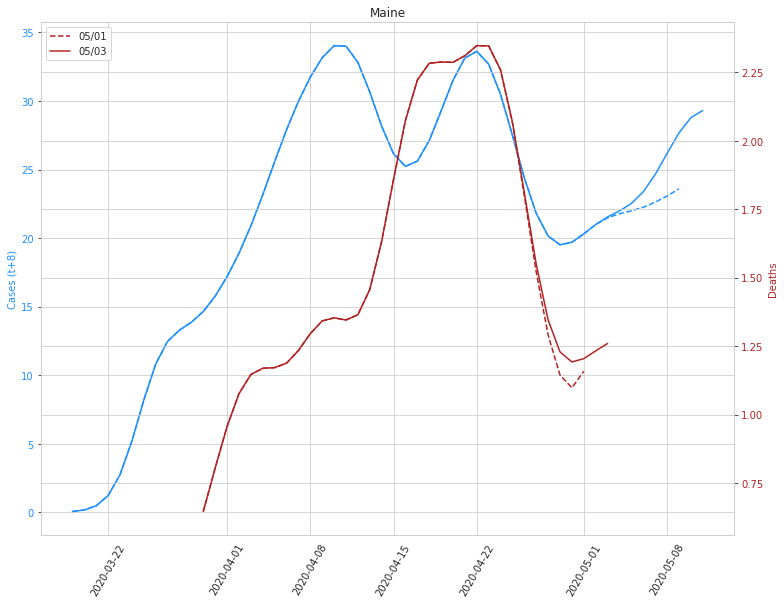

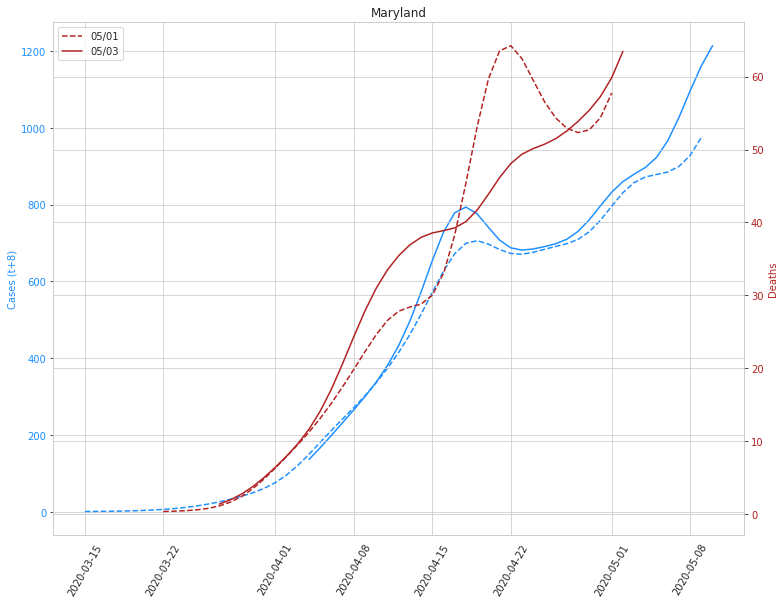

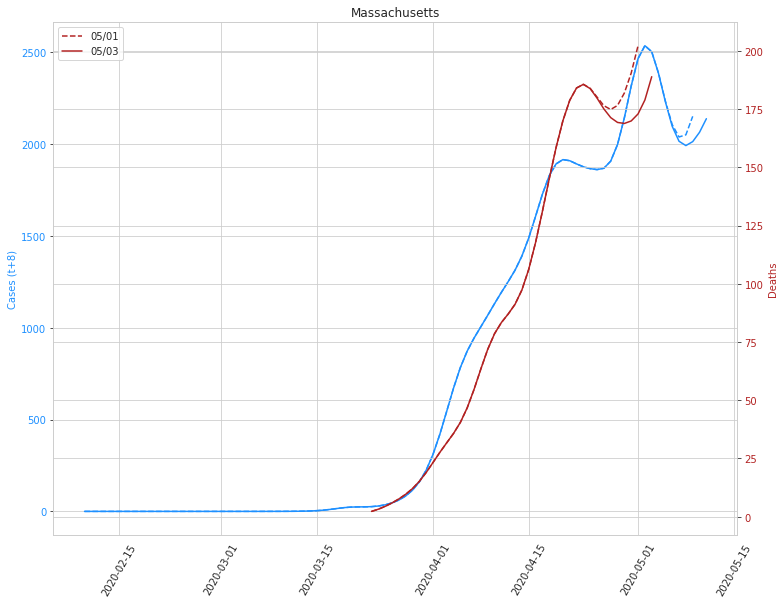

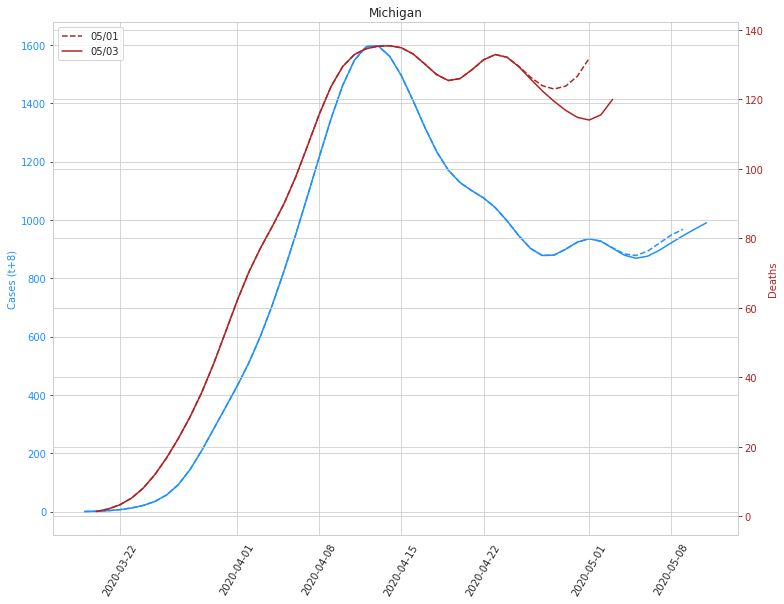

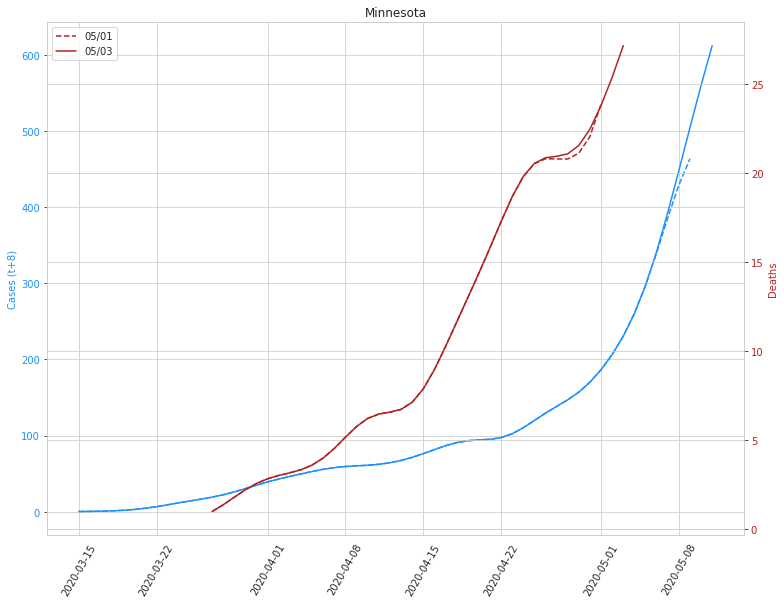

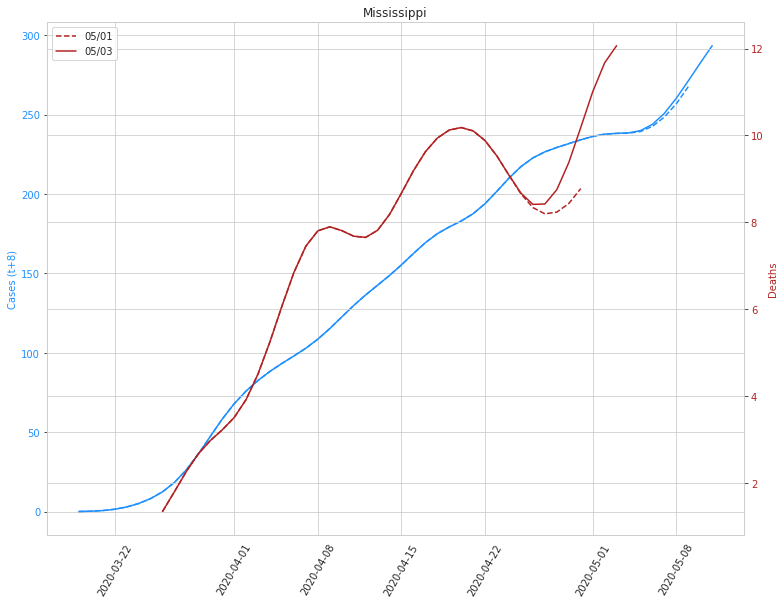

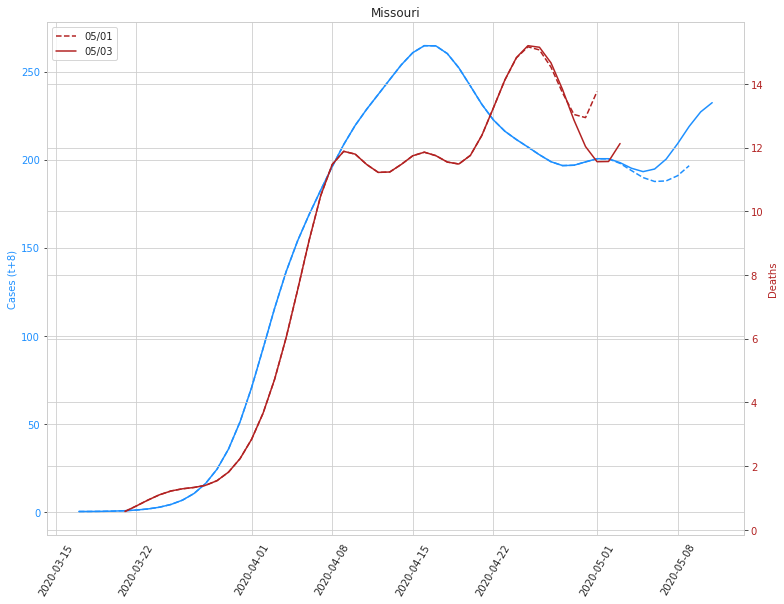

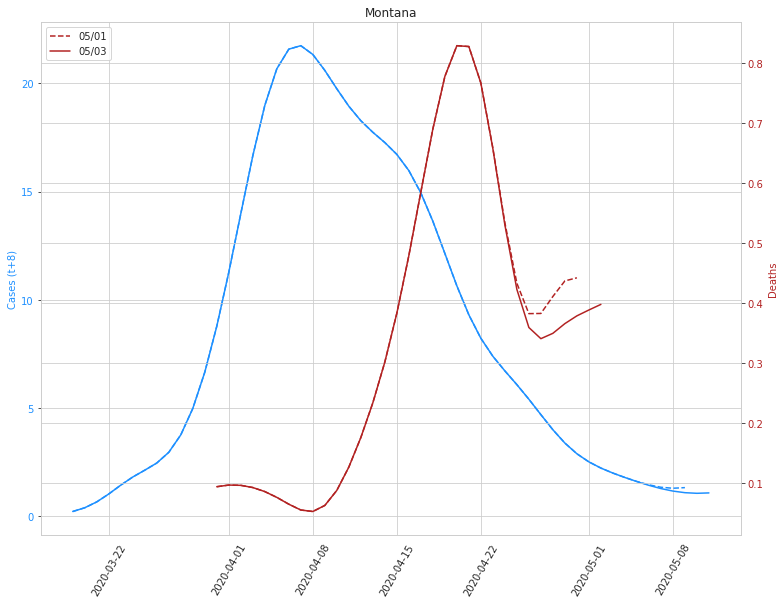

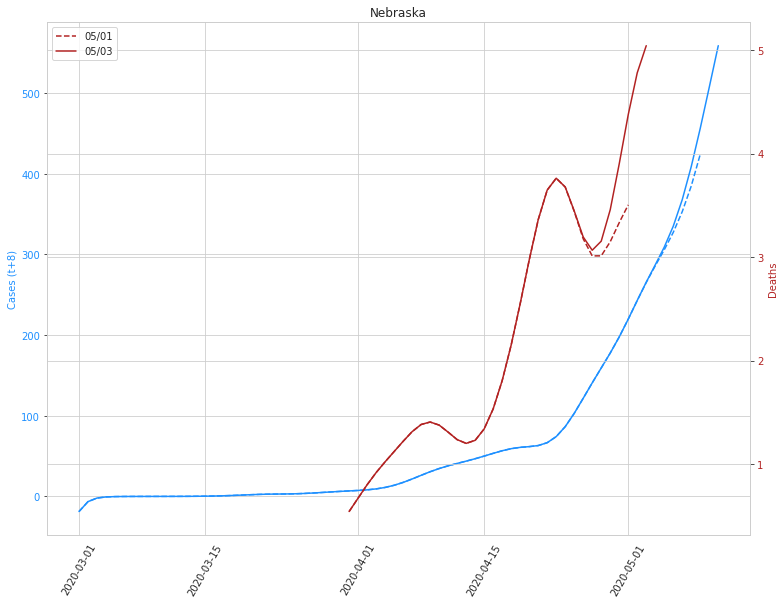

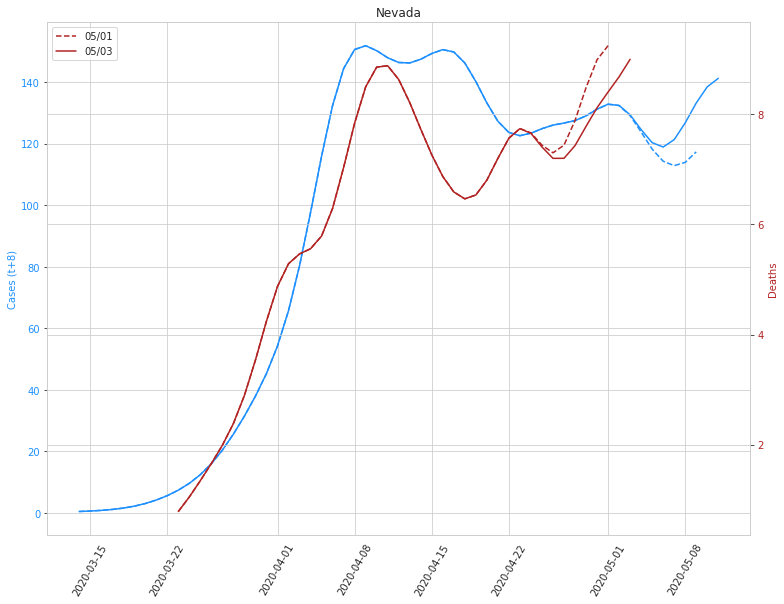

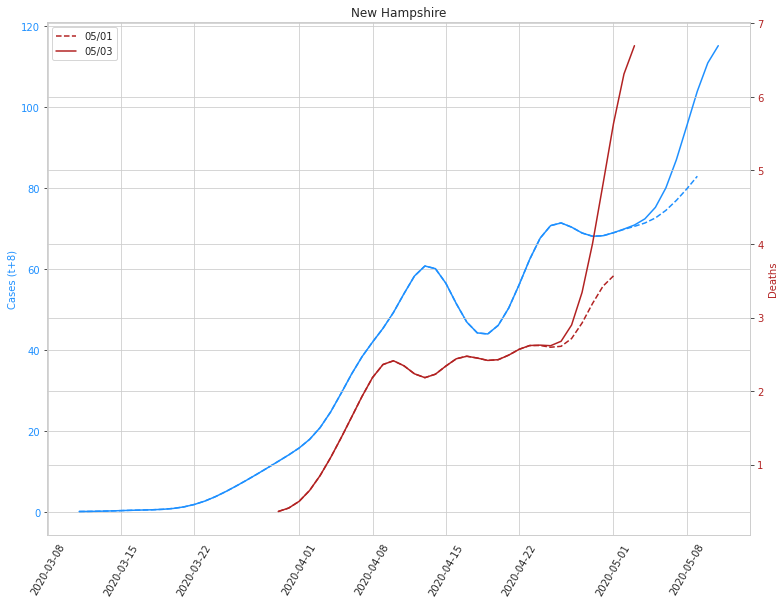

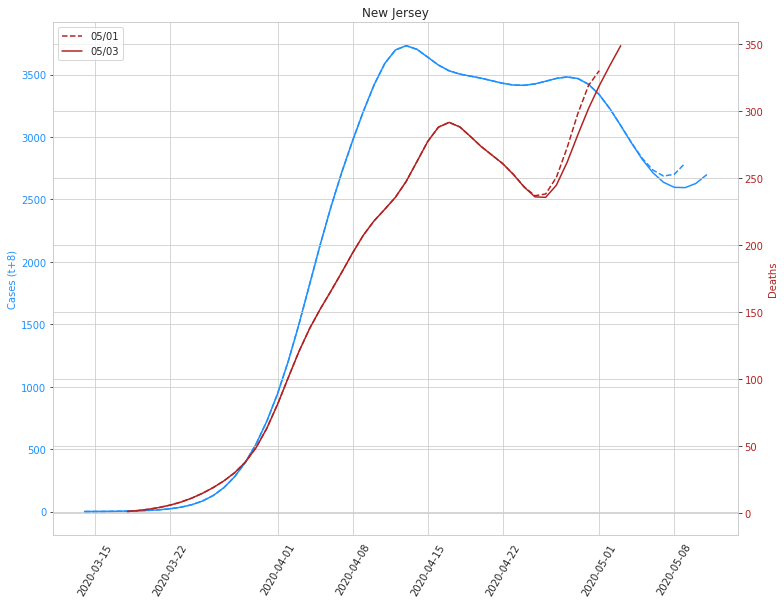

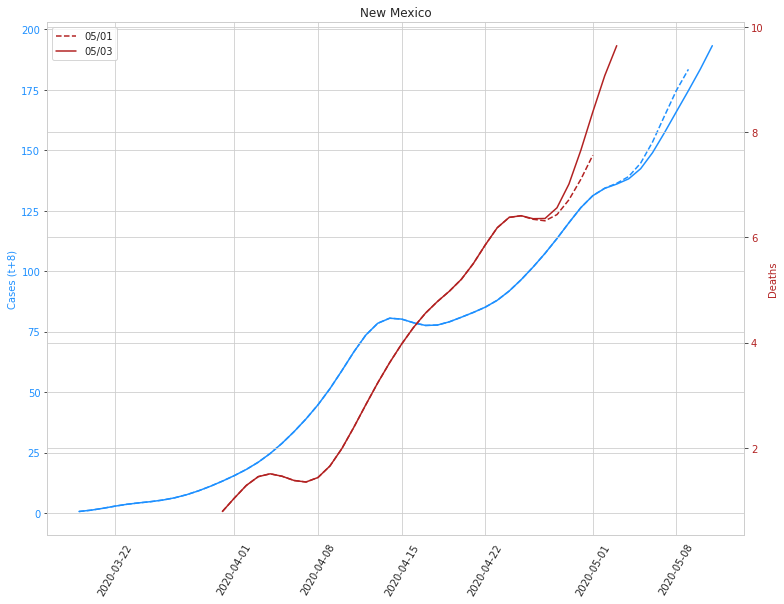

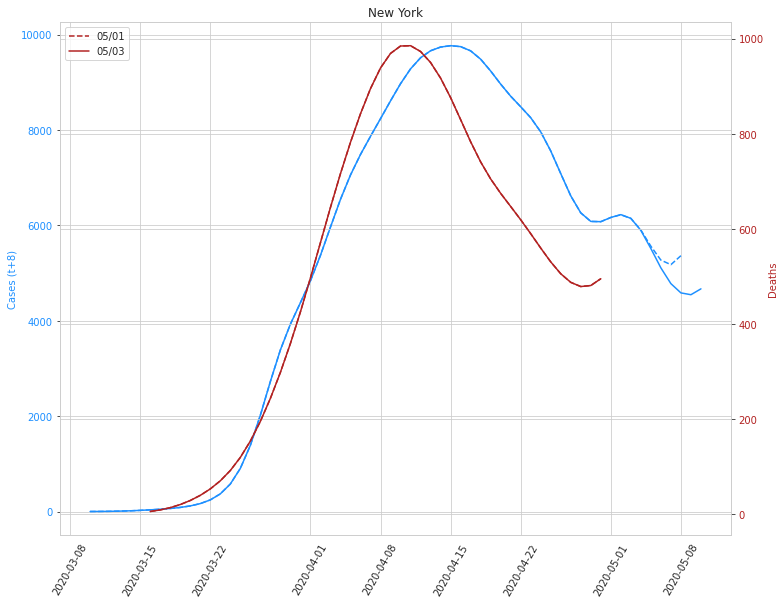

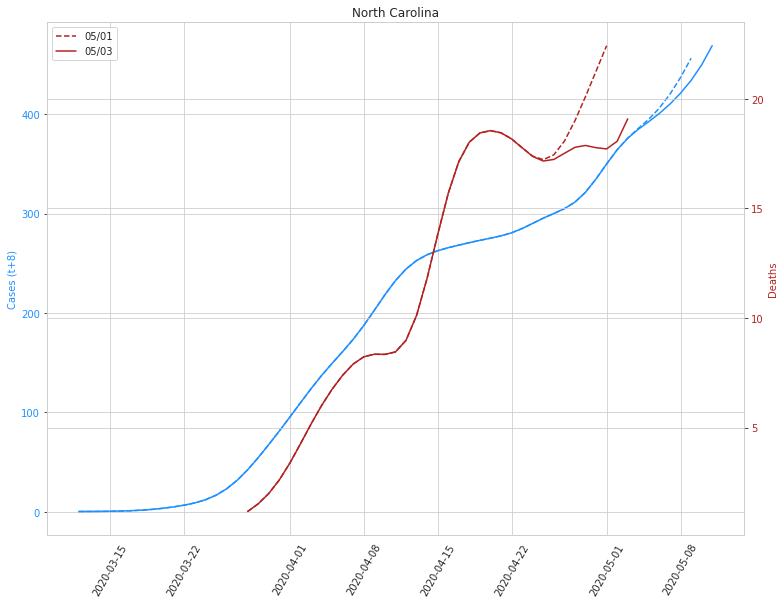

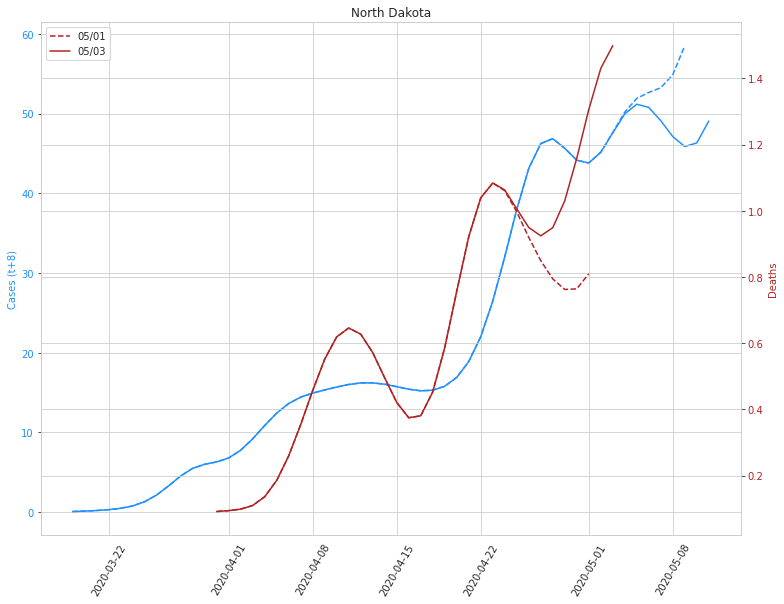

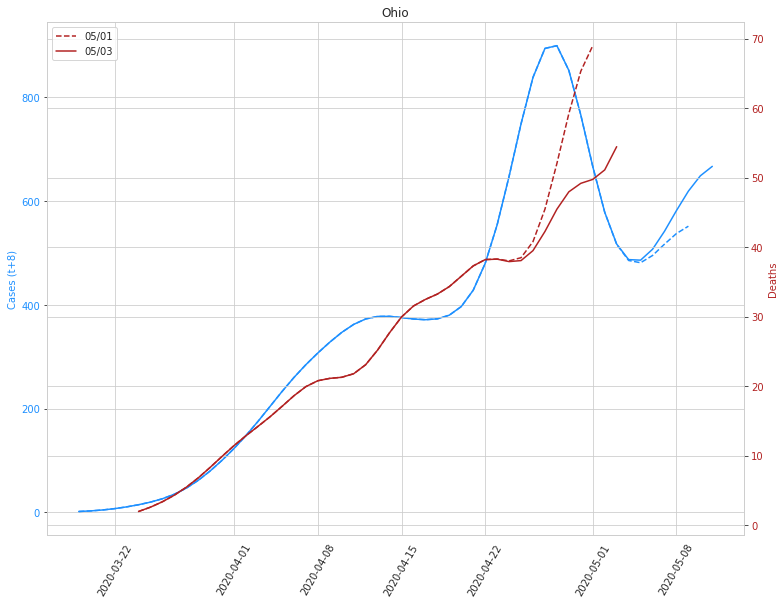

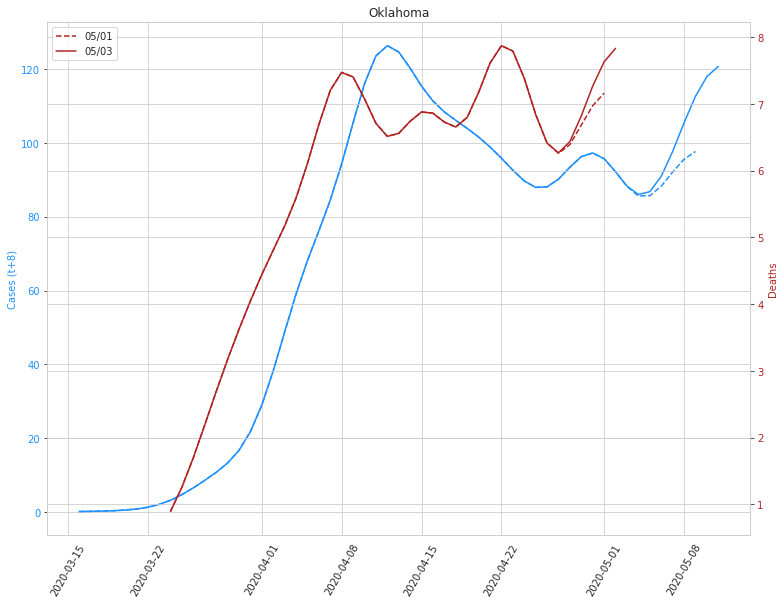

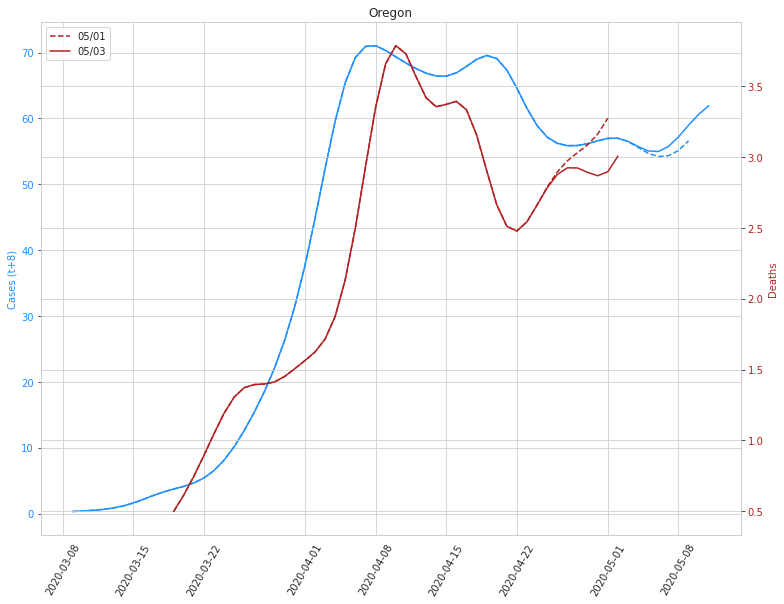

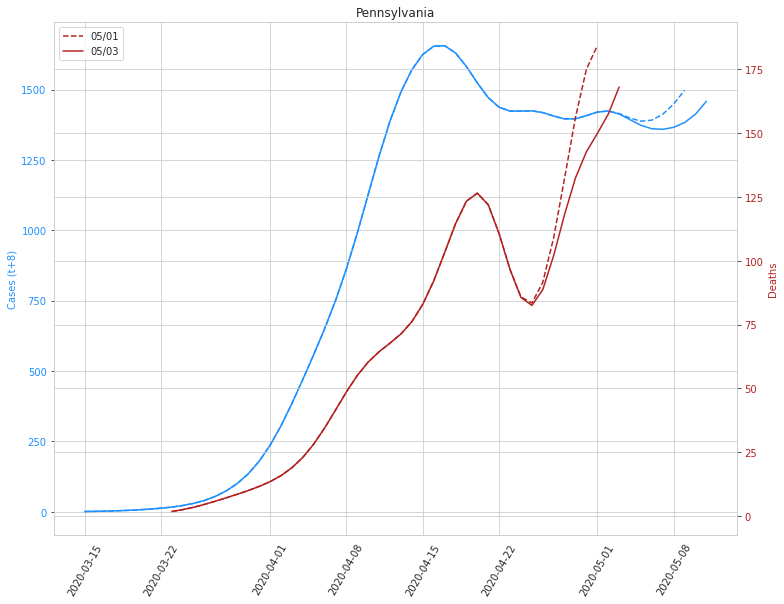

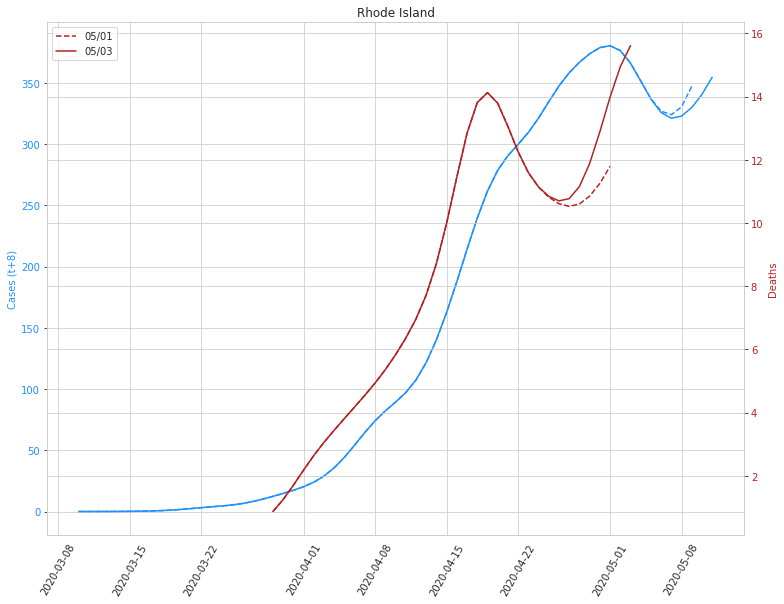

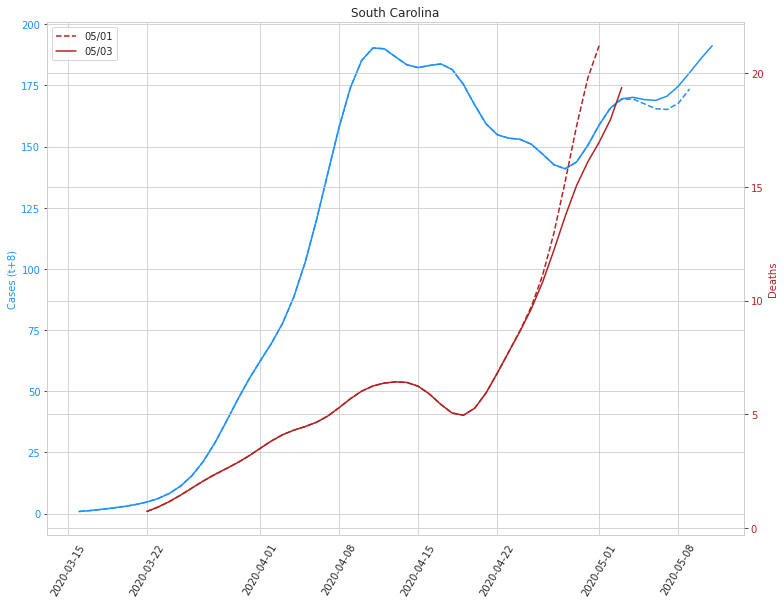

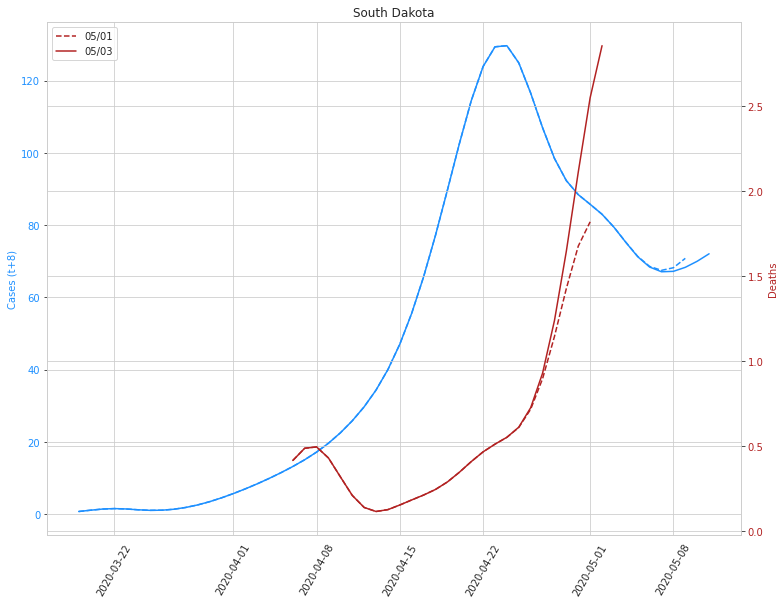

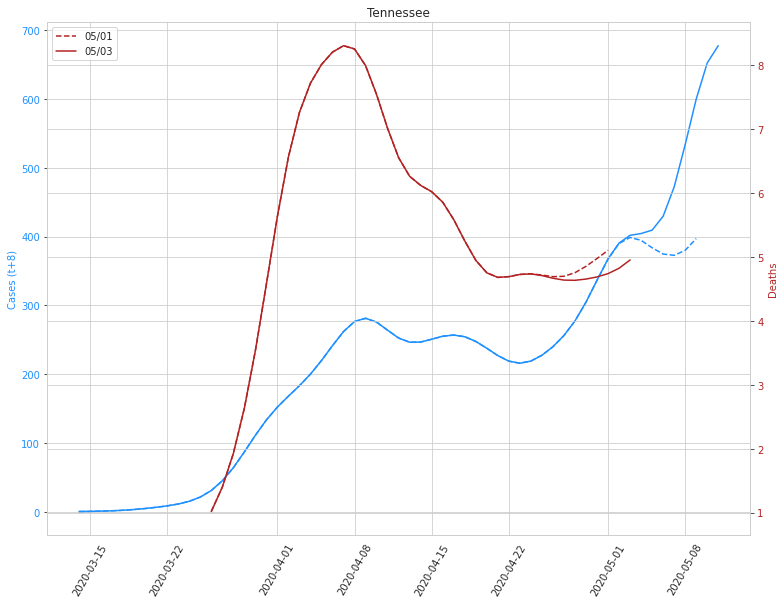

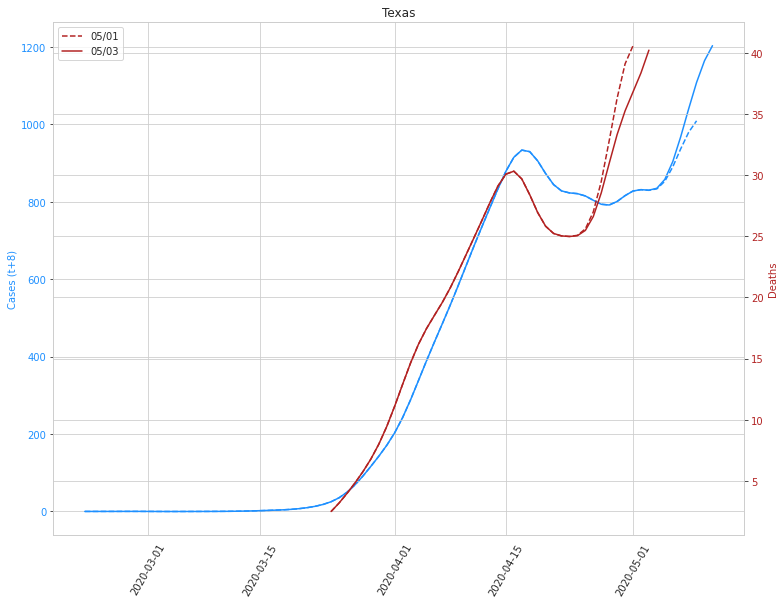

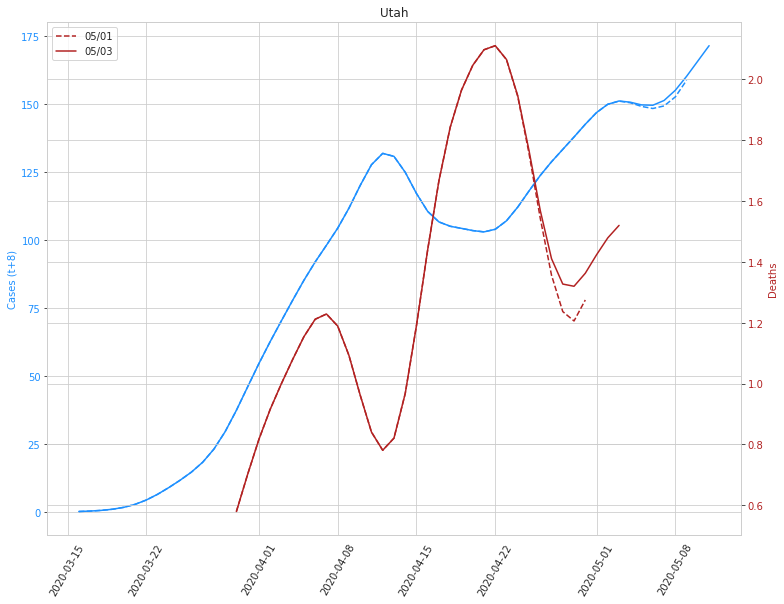

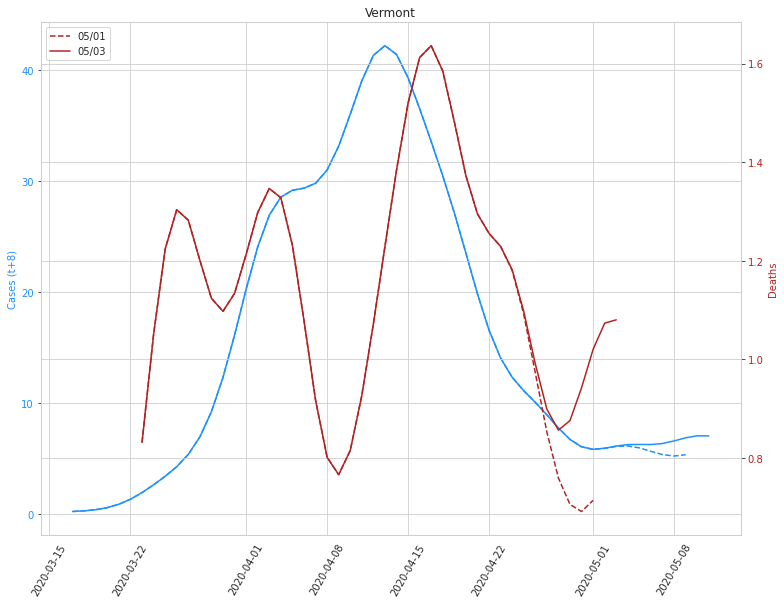

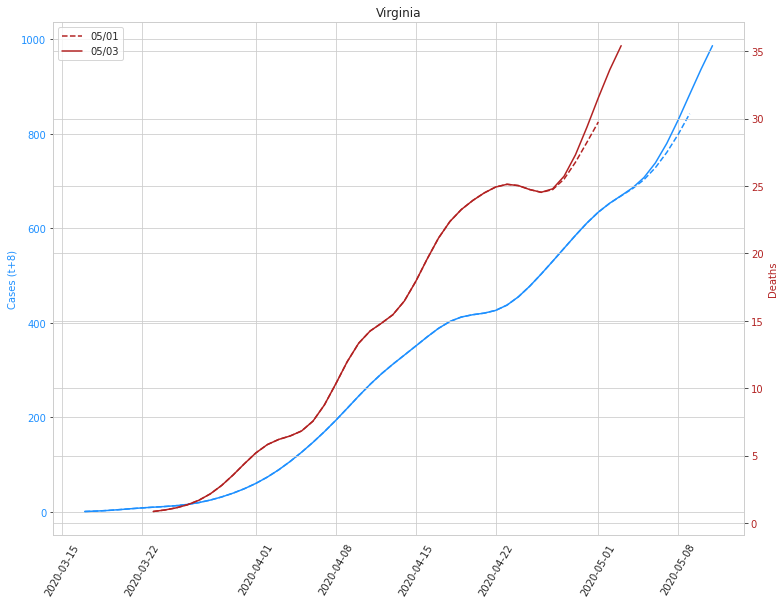

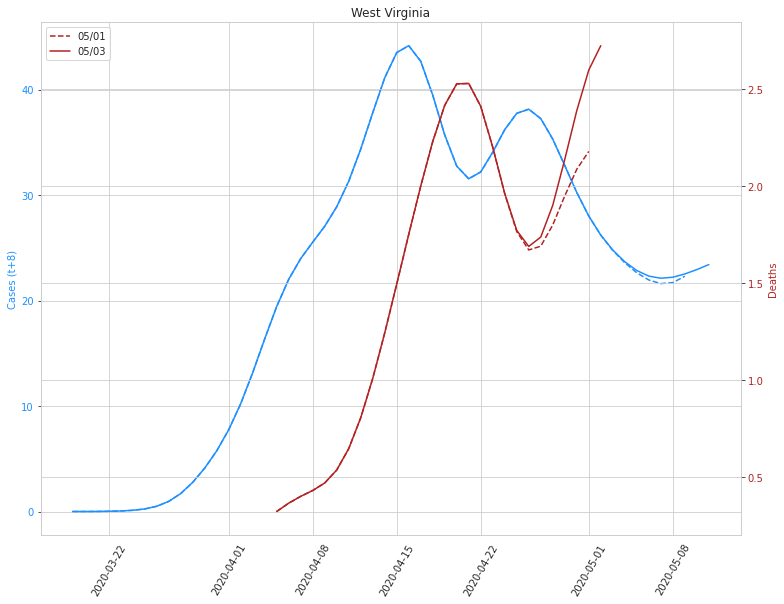

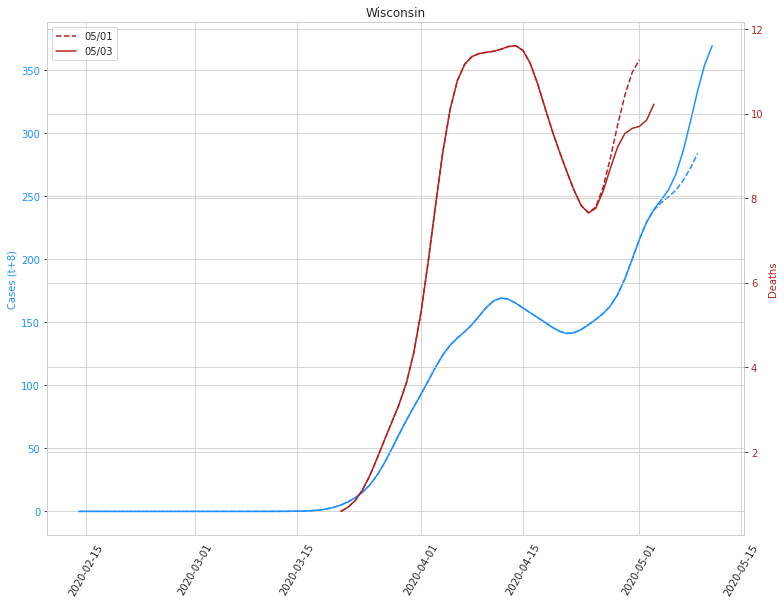

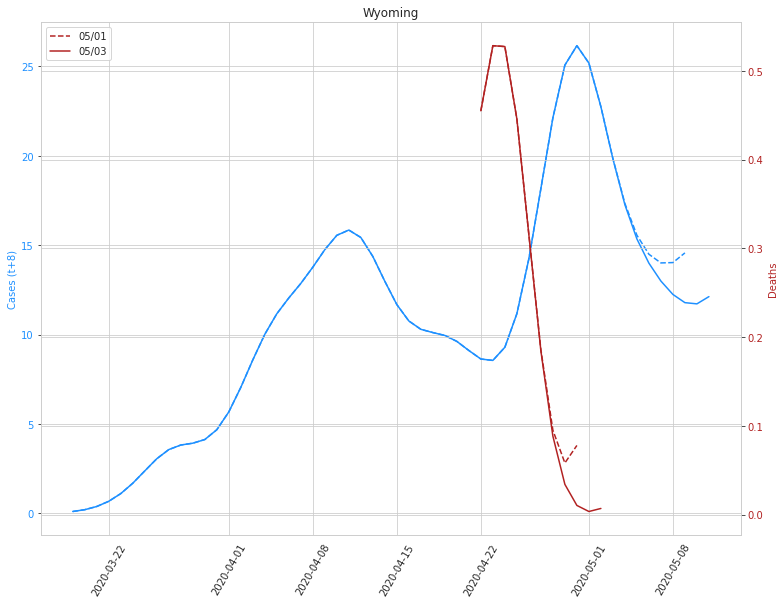

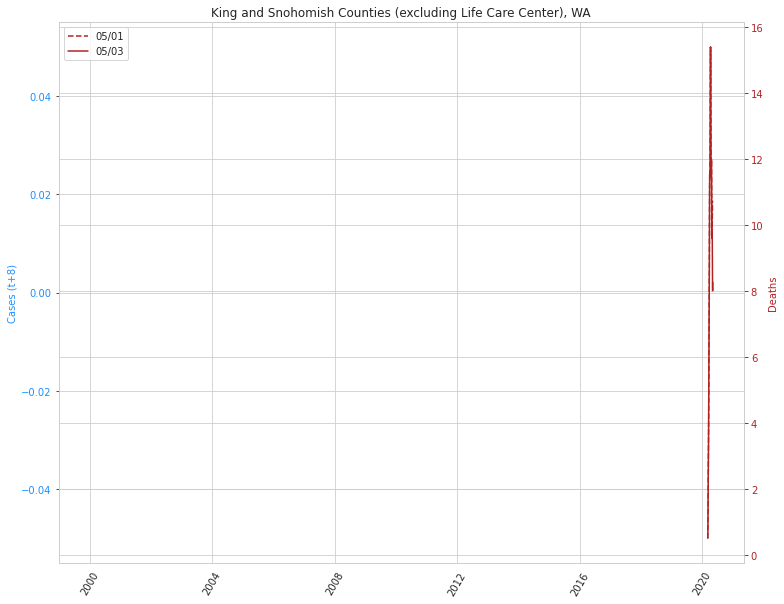

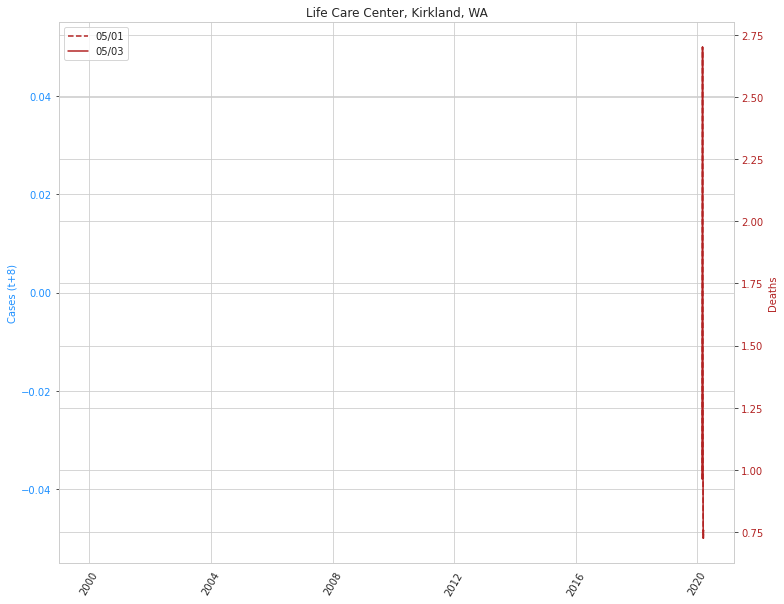

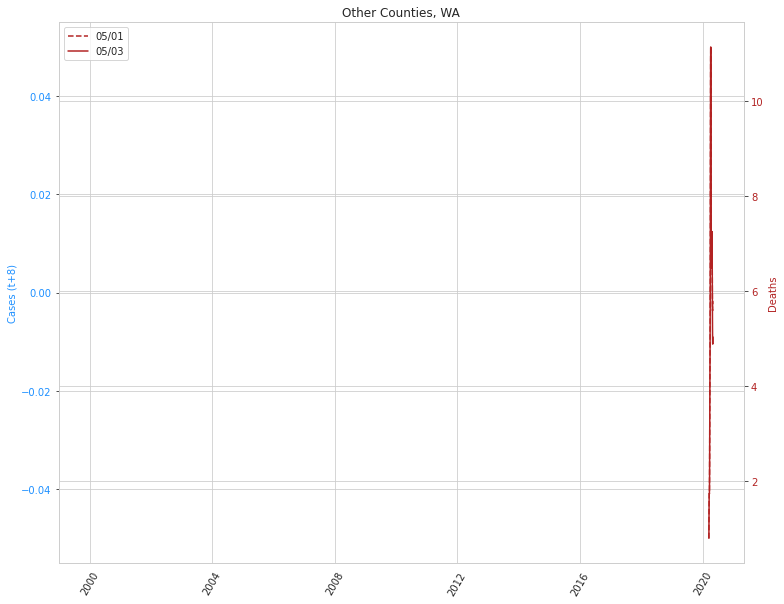

In [44]:
with PdfPages('/ihme/homes/rmbarber/covid-19/smoothed_deaths_cases_t+8_05_03.pdf') as pdf:
    for location_id in location_ids:
        fig, ax1 = plt.subplots(figsize=(11, 8.5))
        ax1.set_ylabel('Cases (t+8)', color='dodgerblue')
        ax1.tick_params(axis='y', labelcolor='dodgerblue')
        ax1.tick_params(axis='x', rotation=60)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Deaths', color='firebrick')
        ax2.tick_params(axis='y', labelcolor='firebrick')
        for date, linestyle in [('05/01', '--'), ('05/03', '-')]:
            if date == '05/01':
                dir_label = '2020_05_01_US_newmod'
            elif date == '05/03':
                dir_label = '2020_05_03_US'
            case_df = pd.read_csv(f'/ihme/covid-19/deaths/prod/{dir_label}/smoothed_cases.csv')
            case_df = case_df.loc[case_df['location_id'] == location_id].reset_index(drop=True)
            case_df['Date'] = pd.to_datetime(case_df['Date'])
            case_df['Date'] = case_df['Date'].apply(lambda x: x + pd.Timedelta(days=8))
            case_df = case_df.sort_values('Date')
            case_df['cases'] = np.exp(case_df['ln(case rate)']) * case_df['population']
            case_dates = case_df['Date'][1:]
            cases = case_df['cases'].values[1:] - case_df['cases'].values[:-1]

            death_df = pd.read_csv(f'/ihme/covid-19/deaths/prod/{dir_label}/model_data_google_21/{location_id}.csv')
            death_df = death_df.loc[death_df['location_id'] == location_id].reset_index(drop=True)
            death_df = death_df.loc[death_df['pseudo'] == 0]
            death_df['Date'] = pd.to_datetime(death_df['Date'])
            death_df = death_df.sort_values('Date')
            death_df['deaths'] = np.exp(death_df['ln(age-standardized death rate)']) * death_df['population']
            death_df = death_df.merge(case_df[['Date']], how='outer')
            death_dates = death_df['Date'][1:]
            deaths = death_df['deaths'].values[1:] - death_df['deaths'].values[:-1]

            
            ax1.plot(case_dates, cases, color='dodgerblue', linestyle=linestyle, label=date)
            ax2.plot(death_dates, deaths, color='firebrick', linestyle=linestyle, label=date)

        plt.legend(loc=2)
        plt.title(death_df['Location'][0])
        plt.tight_layout()
        pdf.savefig()
        